In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
import torchvision
from torchvision import transforms, datasets
import copy
import math
import random
from torch.cuda import amp
torch.manual_seed(0)

In [2]:
# Hyperparameters
beta_start = 1e-4
beta_end = 0.02
steps = 1000
device = "mps"
image_size = 64
image_channel = 3
epochs = 300
lr = 3e-4
weight_decay = 0
batch_size = 100
num_class = 200
pos_dim = 1024

In [3]:
# This is the utils file
def zero_out(layer):
    for p in layer.parameters():
        p.detach().zero_()
    return layer

def positional_embedding_creator(num_step: int, pos_dim: int):
    matrix = torch.zeros(num_step, pos_dim)
    for i in range(num_step):
        for j in range(0, pos_dim, 2):
            matrix[i, j] = np.sin(i/(10000**(j/pos_dim)))
            if(j+1<pos_dim):
                matrix[i, j+1] = np.cos(i/(10000**(j/pos_dim)))

    return matrix

In [4]:
# Diffusion model

# AdaGN according to paper "Diffusion Models Beat GANs on Image Synthesis"
class AdaNorm(nn.Module):
    def __init__(self, num_channel: int):
        super().__init__()
        num_group = int(num_channel/16) # According to group norm paper, 16 channels per group produces the best result
        self.gnorm = nn.GroupNorm(num_group, num_channel, affine=False)

    def forward(self, tensor: torch.Tensor, emb: torch.Tensor):
        scale, shift = torch.chunk(emb, 2, dim=1)

        tensor = self.gnorm(tensor)
        tensor = tensor * (1 + scale) + shift
        return tensor


class MyGroupNorm(nn.Module):
    def __init__(self, num_channel: int):
        super().__init__()
        num_group = int(num_channel/16) # According to group norm paper, 16 channels per group produces the best result
        self.gnorm = nn.GroupNorm(num_group, num_channel, affine=False)

    def forward(self, tensor: torch.Tensor):
        return self.gnorm(tensor)


class ResBlock(nn.Module):
    def __init__(self, in_channel: int, out_channel: int, emb_dim: int = 1024, up: bool = False, down: bool = False):
        super().__init__()
        self.emb = nn.Sequential(nn.SiLU(), nn.Linear(emb_dim, 2*out_channel))
        if up:
            self.change_size = nn.Upsample(scale_factor=2, mode='nearest')
        elif down:
            self.change_size = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            self.change_size = nn.Identity()

        # Normalization
        self.gnorm1 = MyGroupNorm(in_channel)
        self.gnorm2 = AdaNorm(out_channel)

        # Convolution
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = 1)
        if in_channel != out_channel:
            self.conv3 = nn.Conv2d(in_channel, out_channel, kernel_size = 1)
        else:
            self.conv3 = nn.Identity()

        # Combine input stage
        self.input = nn.Sequential(
            self.gnorm1,
            nn.SiLU(),
            self.change_size,
            self.conv1
        )

        # Combine output stage
        self.output = nn.Sequential(
            nn.SiLU(),
            zero_out(self.conv2)
        )

        # Skip connection
        self.skip_connection = nn.Sequential(
            self.change_size,
            self.conv3
        )

        # Embedding
        self.embed = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, 2 * out_channel)
        )

    def forward(self, tensor: torch.Tensor, emb: torch.Tensor):
        emb = self.embed(emb).view(tensor.shape[0], -1, 1, 1)

        h = self.input(tensor)
        h = self.gnorm2(h, emb)
        h = self.output(h)
        x = self.skip_connection(tensor)

        return x + h


class SelfAttention(nn.Module):
    def __init__(self, channel: int):
        super().__init__()
        self.num_head = int(channel/32)

    def forward(self, tensor: torch.Tensor):
        batch, channel, length = tensor.shape
        ch = channel // 3 // self.num_head
        q, k, v = tensor.chunk(3, dim = 1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        # The code below is from Diffusion Model Beat GANs on Image Synthesis paper code
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).view(batch * self.num_head, ch, length),
            (k * scale).view(batch * self.num_head, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(batch * self.num_head, ch, length))
        return a.reshape(batch, -1, length)


class Attention(nn.Module):
    def __init__(self, channel: int):
        super().__init__()
        self.gnorm = MyGroupNorm(channel)
        self.qkv = nn.Conv1d(channel, channel * 3, 1)
        self.attention = SelfAttention(channel)
        self.output = zero_out(nn.Conv1d(channel, channel, 1))

    def forward(self, tensor: torch.Tensor):
        # Perform self attention
        batch, channel, width, height = tensor.shape
        tensor = tensor.reshape(batch, channel, -1)
        # Skip connection
        tensor_skip = tensor
        tensor = self.gnorm(tensor)
        tensor = self.qkv(tensor)
        tensor = self.attention(tensor)
        tensor = self.output(tensor)

        # Adding the skip connection tensor back to the current tensor
        tensor = tensor + tensor_skip

        tensor = tensor.reshape(batch, channel, width, height)
        return tensor


class UNet(nn.Module):
    def __init__(self, image_channel: int = 3, depth: int = 2, emb_dim: int = 1024, num_step = 1000, num_classes = 10):
        super().__init__()

        # Create model architecture
        channels = [160, 320, 544, 608]
        attention_channel = [544, 608]
        self.encoder = nn.ModuleList([nn.ModuleList([nn.Conv2d(image_channel, channels[0], 3, padding=1)])])
        self.decoder = nn.ModuleList()

        skip_channel = [channels[0]]

        # Encoder
        for i in range(len(channels)):
            for _ in range(depth):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i], emb_dim = emb_dim))
                if channels[i] in attention_channel:
                    layer.append(Attention(channels[i]))
                self.encoder.append(layer)
                skip_channel.append(channels[i])

            if i != len(channels)-1:
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i + 1], down=True, emb_dim = emb_dim))
                self.encoder.append(layer)
                skip_channel.append(channels[i+1])

        # Bottleneck
        self.bottle_neck = nn.ModuleList([
            ResBlock(channels[-1], channels[-1]),
            Attention(channels[-1]),
            ResBlock(channels[-1], channels[-1]),
        ])

        # Decoder
        for i in range(len(channels)-1, -1, -1):
            for block in range(depth+1):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i] + skip_channel.pop(), channels[i], emb_dim = emb_dim))
                if channels[i] in attention_channel:
                    layer.append(Attention(channels[i]))

                if i != 0 and block == depth:
                    layer.append(ResBlock(channels[i], channels[i - 1], up=True, emb_dim = emb_dim))

                self.decoder.append(layer)

        # Create time embedding
        self.time_embedding = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )

        # Create class embedding
        self.class_embedding = nn.Embedding(num_classes, emb_dim)

        # Output kernels to change back to image channel
        self.out = nn.Sequential(
            MyGroupNorm(channels[0]),
            nn.SiLU(),
            zero_out(nn.Conv2d(channels[0], image_channel, 3, padding=1)),
        )

    def forward(self, tensor: torch.Tensor, time_embedding: torch.Tensor, label: torch.Tensor | None):
        # Creating embedding
        embedding = self.time_embedding(time_embedding)
        
        if label != None:
            class_embedding = self.class_embedding(label)
            embedding = embedding + class_embedding
        skip_connection = []

        # Encoder
        for layer in self.encoder:
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

            skip_connection.append(tensor)

        # Bottleneck
        for module in self.bottle_neck:
            if(isinstance(module, ResBlock)):
                tensor = module(tensor, embedding)
            else:
                tensor = module(tensor)

        # Decoder
        for layer in self.decoder:
            tensor = torch.concatenate((tensor, skip_connection.pop()), dim = 1)
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

        tensor = self.out(tensor)

        return tensor

class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [5]:
# Constants used for diffusion model
beta = torch.linspace(beta_start, beta_end, steps).to(device)
sqrt_beta = torch.sqrt(beta).view(-1, 1, 1, 1)
alpha = 1 - beta
alphas_cumprod = torch.cumprod(alpha, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).view(-1, 1, 1, 1)
one_minus_alphas_cumprod = 1 - alphas_cumprod
sqrt_one_minus_alphas_cumprod = torch.sqrt(one_minus_alphas_cumprod).view(-1, 1, 1, 1)
one_over_sqrt_alpha = 1/torch.sqrt(alpha).view(-1, 1, 1, 1)
one_minus_alpha = (1 - alpha).view(-1, 1, 1, 1)

In [6]:
# Forward pass
def forward_pass(images, t):
    batch_sqrt_alphas_cumprod = sqrt_alphas_cumprod[t]
    batch_sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod[t]
    noise = torch.randn_like(images).to(device)

    return batch_sqrt_alphas_cumprod * images + batch_sqrt_one_minus_alphas_cumprod * noise, noise

In [7]:
# Positional embedding
pos_emb_matrix = positional_embedding_creator(steps, pos_dim).to(device)

In [8]:
# Sampling(inference)

def sampling(model, labels, cfg_scale: int = 3):
    model.eval()
    with torch.no_grad():
        x = torch.randn(labels.shape[0], image_channel, image_size, image_size).to(device)

        for i in range(steps-1, -1, -1):
            t = torch.tensor([i]*labels.shape[0]).to(device)
            pos_emb = pos_emb_matrix[t]

            # Classifier free guidance
            predicted_noise_no_label = model(x, pos_emb, None)
            predicted_noise_with_label = model(x, pos_emb, labels)
            predicted_noise = torch.lerp(predicted_noise_no_label, predicted_noise_with_label, cfg_scale)

            if(i == 0):
                noise = torch.zeros_like(x).to(device)
            else:
                noise = torch.randn_like(x).to(device)

            x = one_over_sqrt_alpha[t] * (x - ((one_minus_alpha[t])/(sqrt_one_minus_alphas_cumprod[t]))*predicted_noise) + sqrt_beta[t] * noise

    model.train()

    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)

    for i in range(x.shape[0]):
        tensor = x[i].permute(1, 2, 0).to("cpu")
        plt.imshow(tensor)
        plt.show()

In [9]:
# Define the transformation\n",
transform = transforms.Compose([
    transforms.Resize(125),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load the test set
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the combined dataset
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Instantiate the model
unet = UNet(num_classes=num_class).to(device)
print("This model has", sum(p.numel() for p in unet.parameters()), "parameters.")
scaler = amp.GradScaler()
loss_train = []
loss_valid = []

This model has 227992835 parameters.


/Users/techlab/Documents/GitHub/Diffusion-CIFAR10/.venv/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [11]:
# Set up optimizer and loss
optimizer = opt.AdamW(unet.parameters(), lr = lr, weight_decay = weight_decay)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.991)

  0%|                                                   | 0/500 [00:00<?, ?it/s]/Users/techlab/Documents/GitHub/Diffusion-CIFAR10/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [12:06<00:00, 13.77it/s]


Epoch #0
Current learning rate is 0.00029729999999999996
Train Loss is: 0.03621906894352287
Valid Loss is: 0.012862532054059557


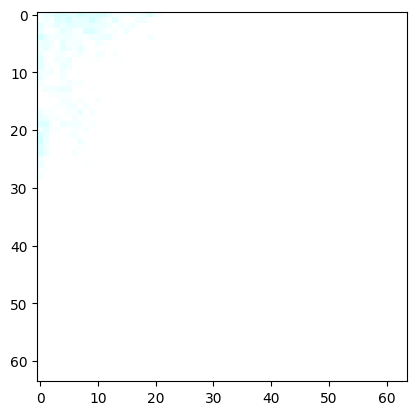

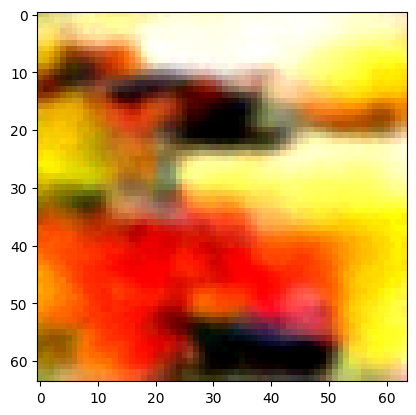

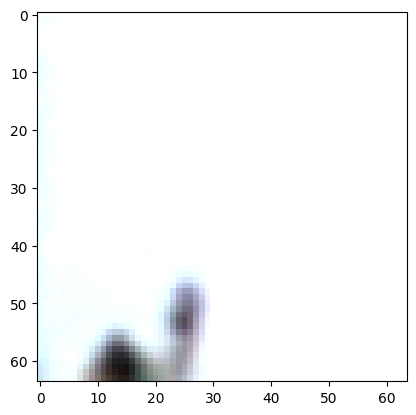

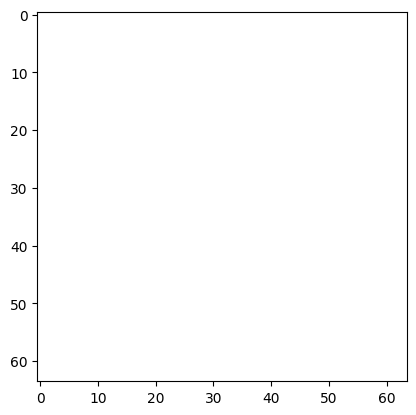

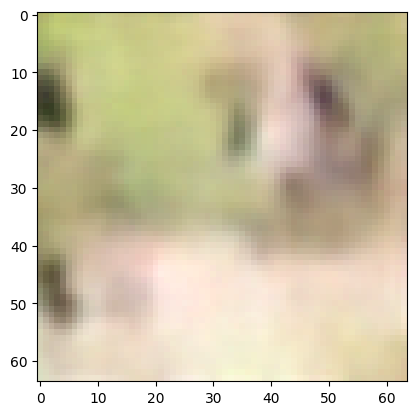

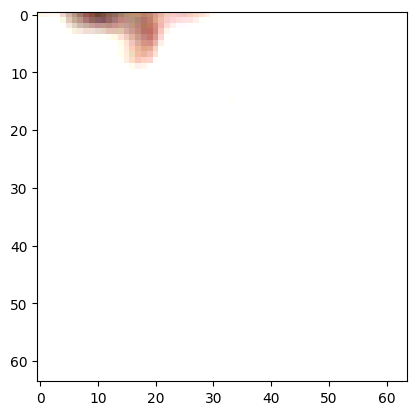

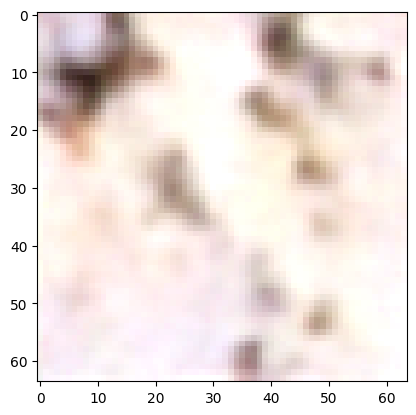

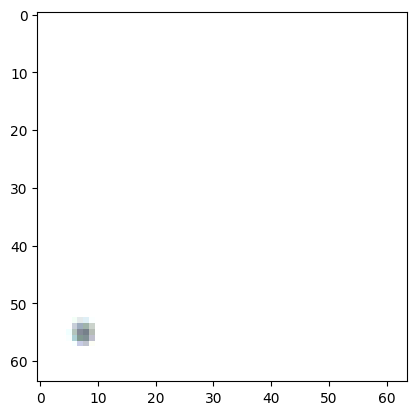

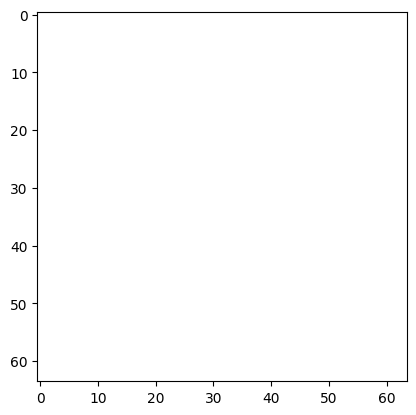

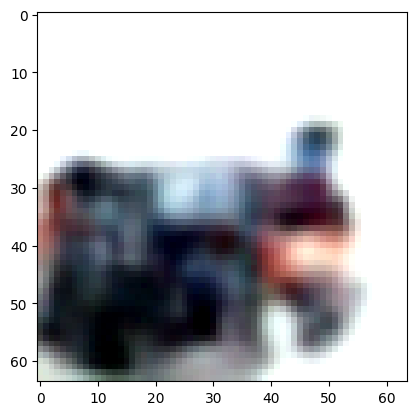

100%|█████████████████████████████████████████| 500/500 [34:40<00:00,  4.16s/it]


Epoch #1
Current learning rate is 0.00029462429999999994
Train Loss is: 0.012468846803531051


100%|█████████████████████████████████████████| 500/500 [34:38<00:00,  4.16s/it]


Epoch #2
Current learning rate is 0.00029197268129999997
Train Loss is: 0.011551109218969942


100%|█████████████████████████████████████████| 500/500 [34:41<00:00,  4.16s/it]


Epoch #3
Current learning rate is 0.00028934492716829995
Train Loss is: 0.011403325824066996


100%|█████████████████████████████████████████| 500/500 [35:13<00:00,  4.23s/it]


Epoch #4
Current learning rate is 0.00028674082282378524
Train Loss is: 0.011058697658590973


100%|█████████████████████████████████████████| 500/500 [35:14<00:00,  4.23s/it]


Epoch #5
Current learning rate is 0.0002841601554183712
Train Loss is: 0.010710239165462553


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.23s/it]


Epoch #6
Current learning rate is 0.00028160271401960586
Train Loss is: 0.01072900303080678


100%|█████████████████████████████████████████| 500/500 [35:13<00:00,  4.23s/it]


Epoch #7
Current learning rate is 0.0002790682895934294
Train Loss is: 0.010893937752582133


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.23s/it]


Epoch #8
Current learning rate is 0.00027655667498708853
Train Loss is: 0.010687903097830713


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.22s/it]


Epoch #9
Current learning rate is 0.00027406766491220474
Train Loss is: 0.010452222117222845


100%|█████████████████████████████████████| 10000/10000 [12:09<00:00, 13.70it/s]


Epoch #10
Current learning rate is 0.0002716010559279949
Train Loss is: 0.010510894517414273
Valid Loss is: 0.010485386967263184


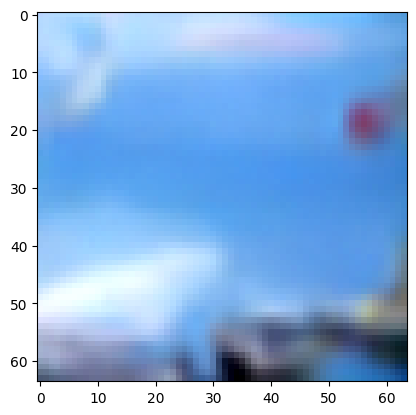

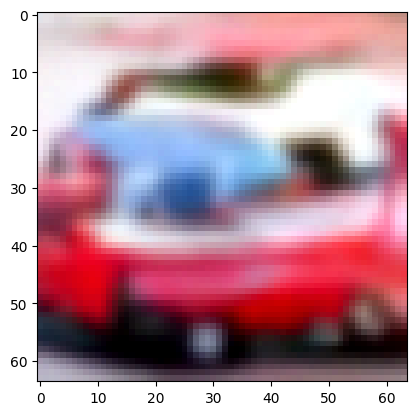

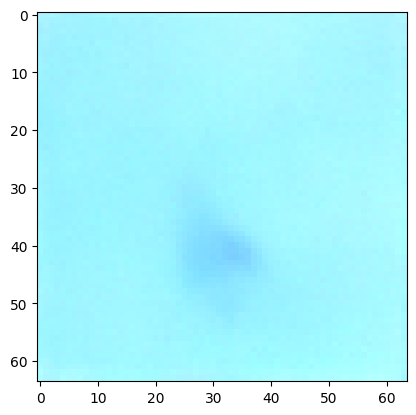

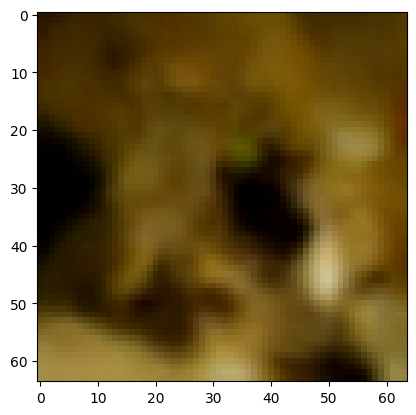

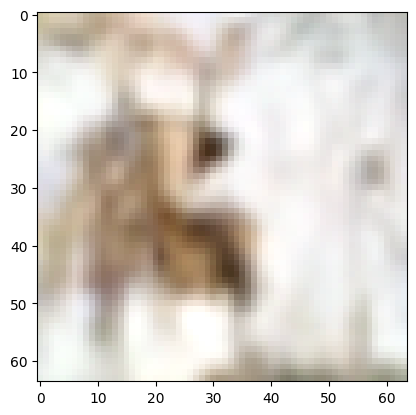

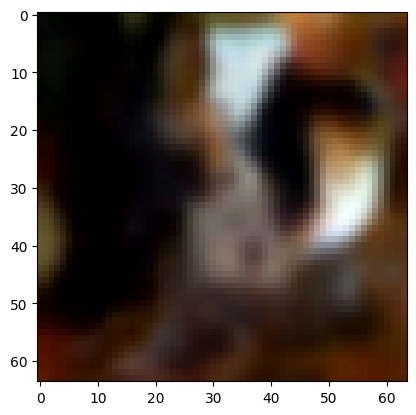

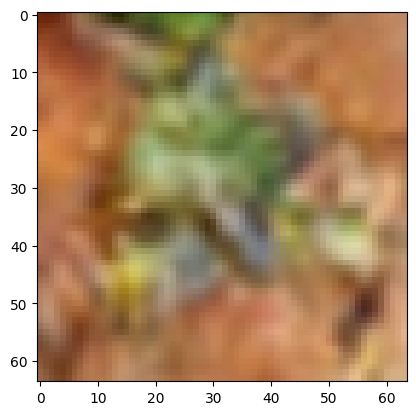

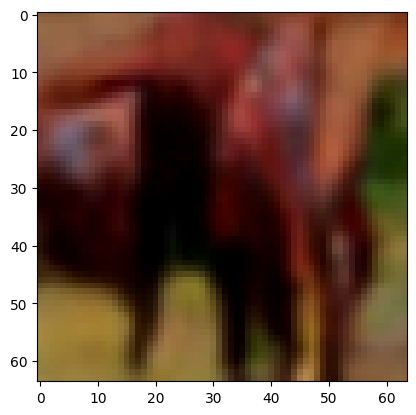

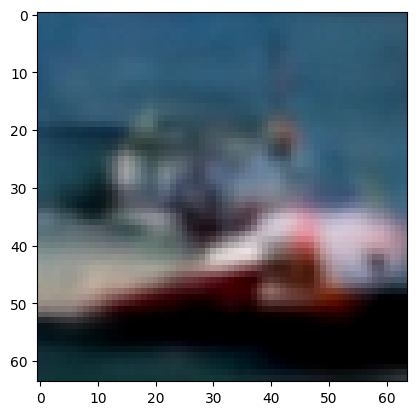

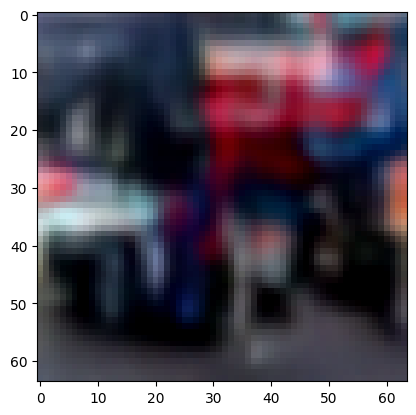

100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #11
Current learning rate is 0.0002691566464246429
Train Loss is: 0.01048400551173836


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #12
Current learning rate is 0.00026673423660682113
Train Loss is: 0.010358210818842053


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #13
Current learning rate is 0.00026433362847735973
Train Loss is: 0.010102934895083309


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #14
Current learning rate is 0.0002619546258210635
Train Loss is: 0.010295323442667722


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #15
Current learning rate is 0.0002595970341886739
Train Loss is: 0.010251876302063465


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #16
Current learning rate is 0.0002572606608809758
Train Loss is: 0.010149208586663008


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #17
Current learning rate is 0.000254945314933047
Train Loss is: 0.010245797616429627


100%|█████████████████████████████████████████| 500/500 [35:08<00:00,  4.22s/it]


Epoch #18
Current learning rate is 0.00025265080709864957
Train Loss is: 0.010161679927259684


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #19
Current learning rate is 0.0002503769498347617
Train Loss is: 0.010053585100919008


100%|█████████████████████████████████████| 10000/10000 [12:07<00:00, 13.74it/s]


Epoch #20
Current learning rate is 0.00024812355728624883
Train Loss is: 0.010169012719765306
Valid Loss is: 0.010081341413493646


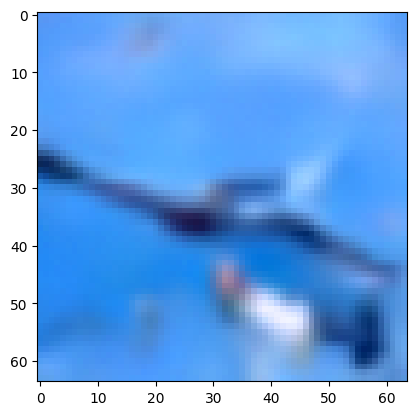

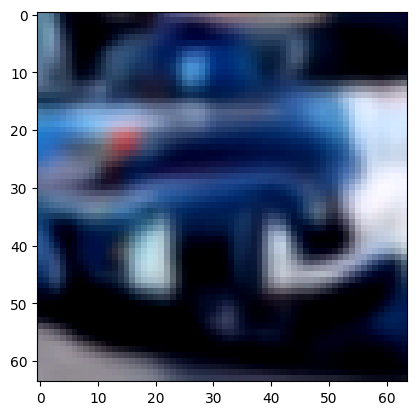

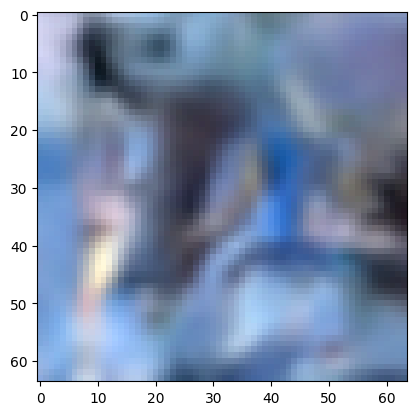

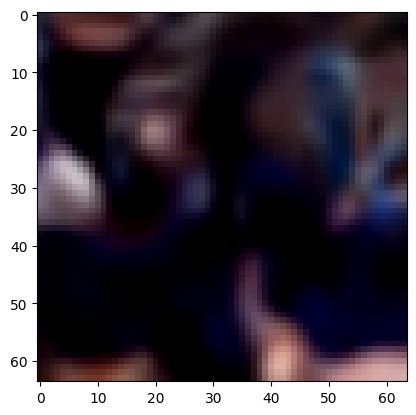

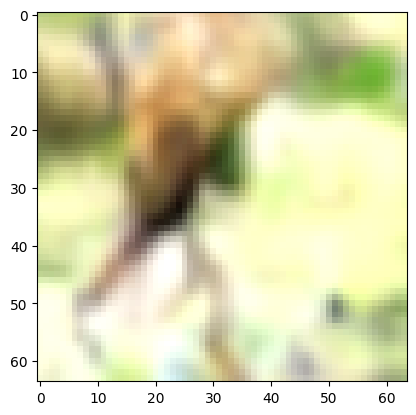

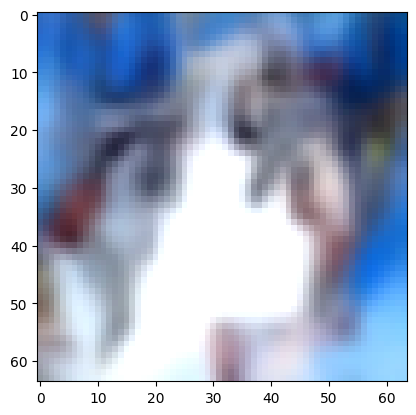

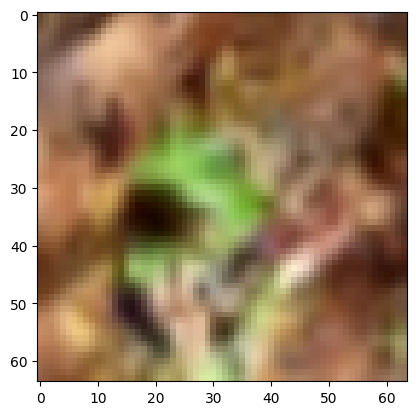

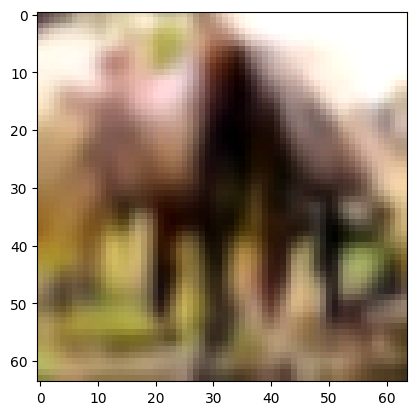

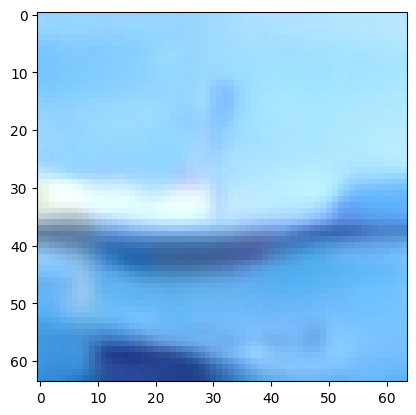

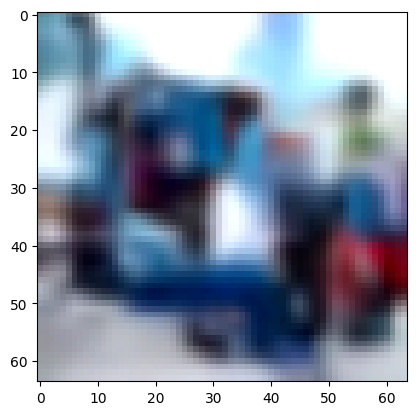

100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #21
Current learning rate is 0.00024589044527067257
Train Loss is: 0.010000121273100376


100%|█████████████████████████████████████████| 500/500 [35:07<00:00,  4.22s/it]


Epoch #22
Current learning rate is 0.0002436774312632365
Train Loss is: 0.010126381858251989


100%|█████████████████████████████████████████| 500/500 [35:07<00:00,  4.21s/it]


Epoch #23
Current learning rate is 0.00024148433438186736
Train Loss is: 0.01013070848211646


100%|█████████████████████████████████████████| 500/500 [35:07<00:00,  4.21s/it]


Epoch #24
Current learning rate is 0.00023931097537243057
Train Loss is: 0.010035519731231034


100%|█████████████████████████████████████████| 500/500 [35:06<00:00,  4.21s/it]


Epoch #25
Current learning rate is 0.00023715717659407868
Train Loss is: 0.009928007534705102


100%|█████████████████████████████████████████| 500/500 [35:07<00:00,  4.21s/it]


Epoch #26
Current learning rate is 0.00023502276200473198
Train Loss is: 0.009925992980599404


100%|█████████████████████████████████████████| 500/500 [35:06<00:00,  4.21s/it]


Epoch #27
Current learning rate is 0.00023290755714668938
Train Loss is: 0.009806680493056774


100%|█████████████████████████████████████████| 500/500 [35:08<00:00,  4.22s/it]


Epoch #28
Current learning rate is 0.00023081138913236916
Train Loss is: 0.009908856076188386


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #29
Current learning rate is 0.00022873408663017783
Train Loss is: 0.009726427097804845


100%|█████████████████████████████████████| 10000/10000 [12:06<00:00, 13.76it/s]


Epoch #30
Current learning rate is 0.00022667547985050622
Train Loss is: 0.009846207056194543
Valid Loss is: 0.009861774758017054


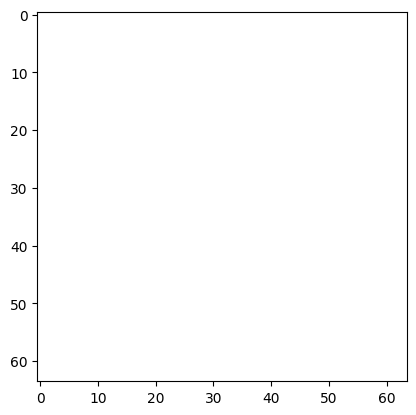

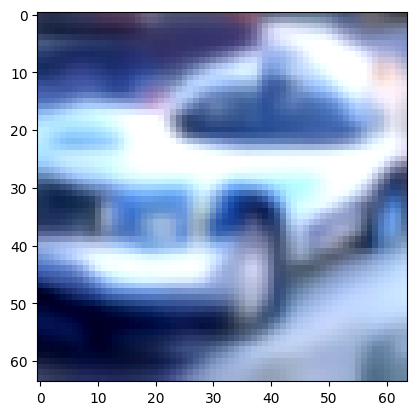

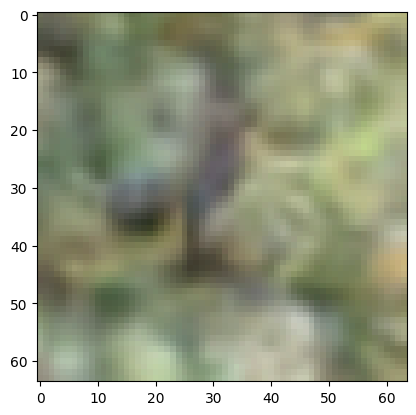

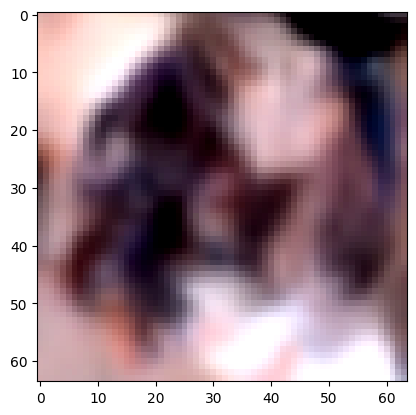

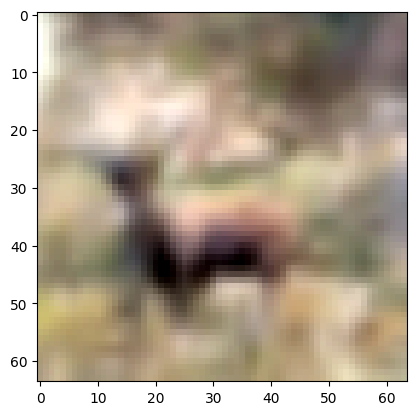

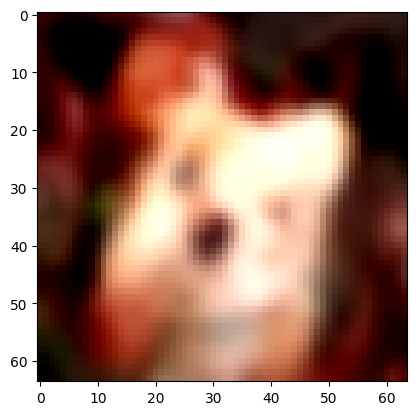

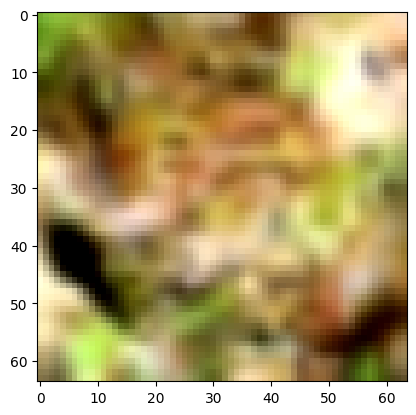

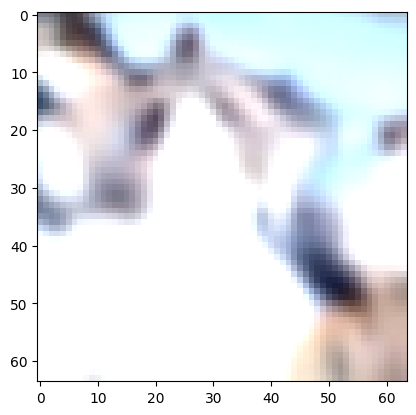

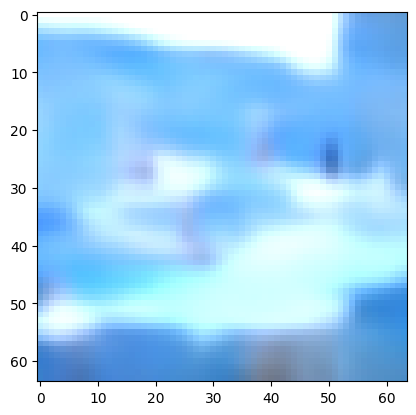

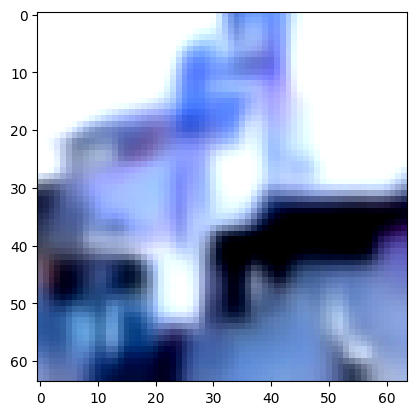

100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #31
Current learning rate is 0.00022463540053185166
Train Loss is: 0.009849483785219491


100%|█████████████████████████████████████████| 500/500 [35:08<00:00,  4.22s/it]


Epoch #32
Current learning rate is 0.00022261368192706498
Train Loss is: 0.009901089195162058


100%|█████████████████████████████████████████| 500/500 [35:16<00:00,  4.23s/it]


Epoch #33
Current learning rate is 0.00022061015878972138
Train Loss is: 0.00991407287027687


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #34
Current learning rate is 0.00021862466736061387
Train Loss is: 0.009659175597131251


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #35
Current learning rate is 0.00021665704535436836
Train Loss is: 0.009881896157748997


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #36
Current learning rate is 0.00021470713194617904
Train Loss is: 0.009855011730454862


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #37
Current learning rate is 0.00021277476775866344
Train Loss is: 0.009750561655499042


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #38
Current learning rate is 0.00021085979484883547
Train Loss is: 0.009749211916700005


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #39
Current learning rate is 0.00020896205669519594
Train Loss is: 0.009805836118757724


100%|█████████████████████████████████████| 10000/10000 [12:11<00:00, 13.68it/s]


Epoch #40
Current learning rate is 0.00020708139818493917
Train Loss is: 0.009683857897296548
Valid Loss is: 0.00951142441552438


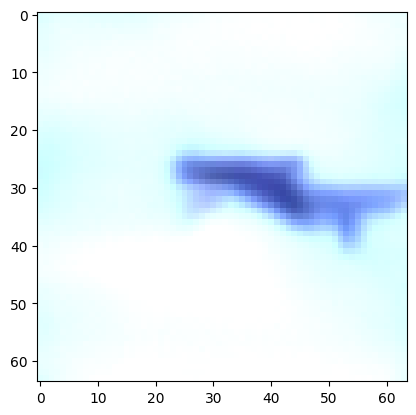

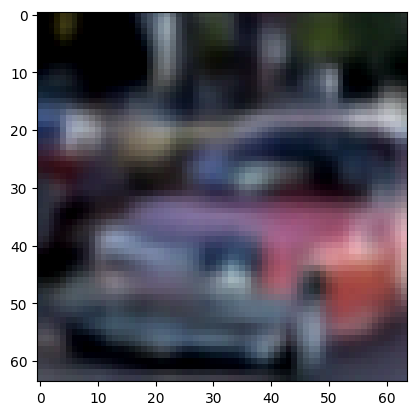

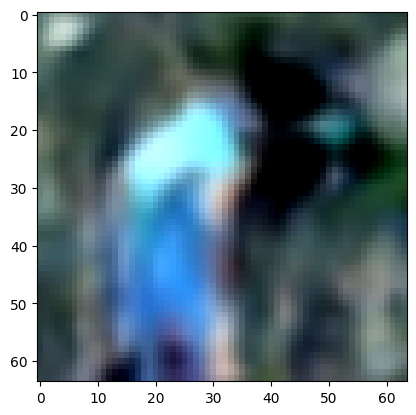

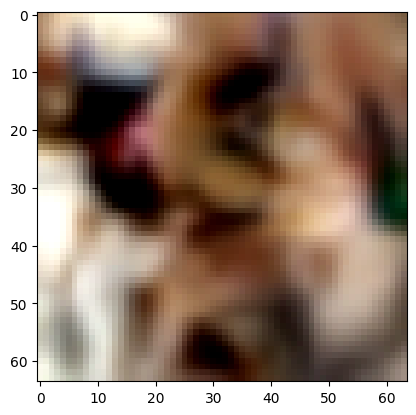

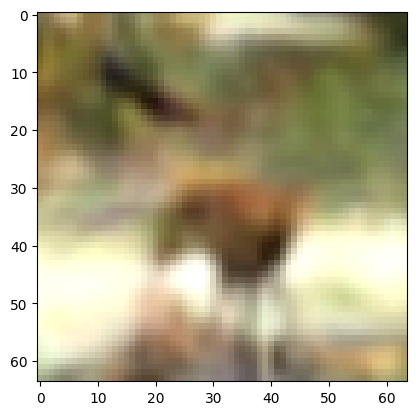

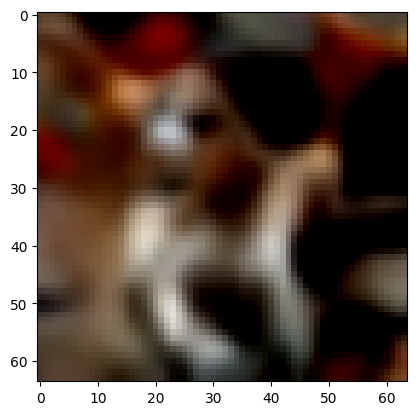

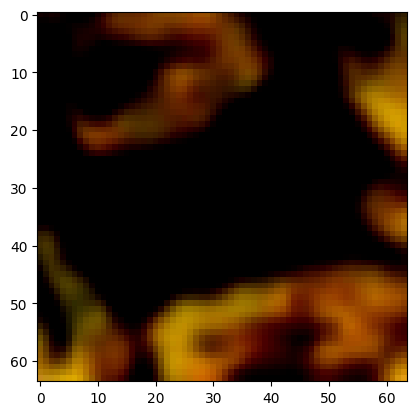

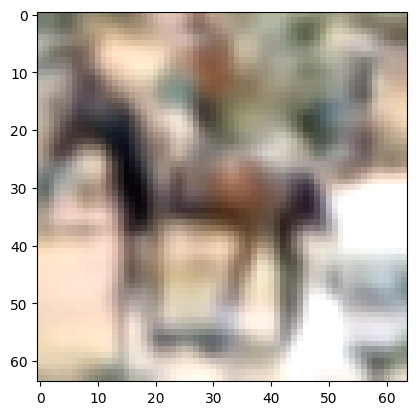

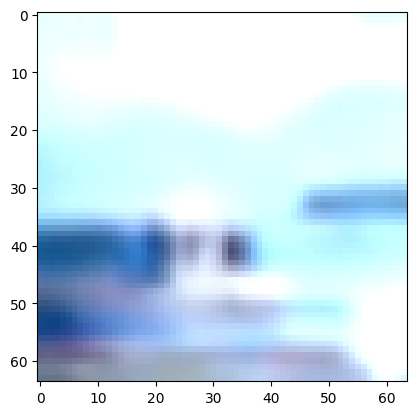

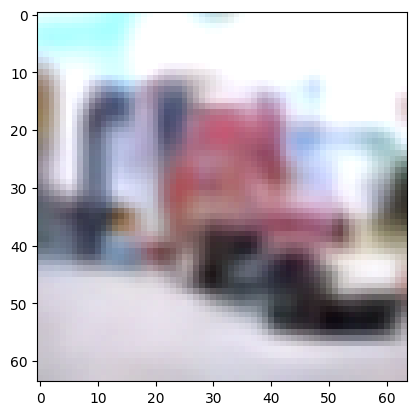

100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #41
Current learning rate is 0.00020521766560127472
Train Loss is: 0.009736925800330937


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #42
Current learning rate is 0.00020337070661086325
Train Loss is: 0.009697347252629697


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #43
Current learning rate is 0.00020154037025136548
Train Loss is: 0.009705967499874532


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #44
Current learning rate is 0.0001997265069191032
Train Loss is: 0.009624383764341474


100%|█████████████████████████████████████████| 500/500 [35:08<00:00,  4.22s/it]


Epoch #45
Current learning rate is 0.00019792896835683126
Train Loss is: 0.009795788957737386


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #46
Current learning rate is 0.00019614760764161978
Train Loss is: 0.009634798559360206


100%|█████████████████████████████████████████| 500/500 [35:08<00:00,  4.22s/it]


Epoch #47
Current learning rate is 0.0001943822791728452
Train Loss is: 0.009682643093168736


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.22s/it]


Epoch #48
Current learning rate is 0.0001926328386602896
Train Loss is: 0.009635048722848295


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #49
Current learning rate is 0.000190899143112347
Train Loss is: 0.009883469264954328


100%|█████████████████████████████████████| 10000/10000 [12:10<00:00, 13.68it/s]


Epoch #50
Current learning rate is 0.00018918105082433586
Train Loss is: 0.009676042227074504
Valid Loss is: 0.009430118620373469


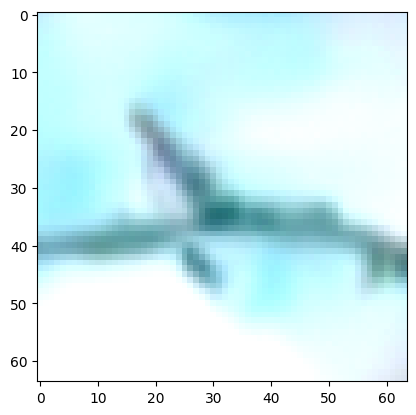

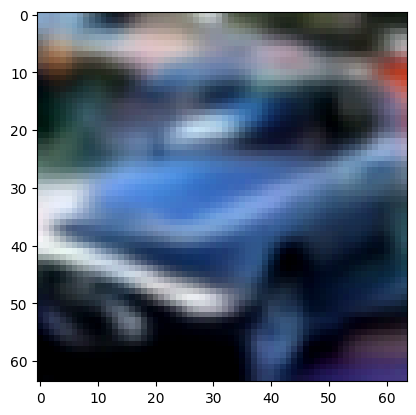

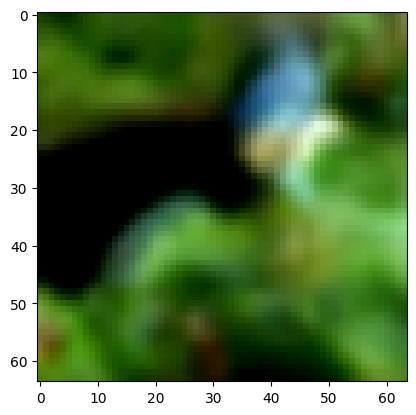

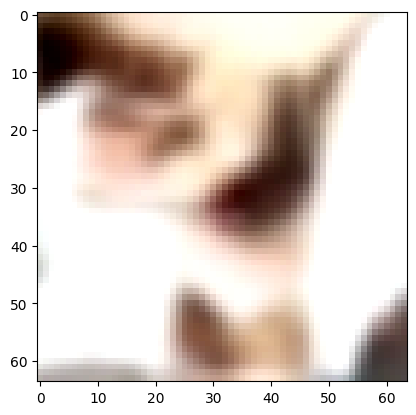

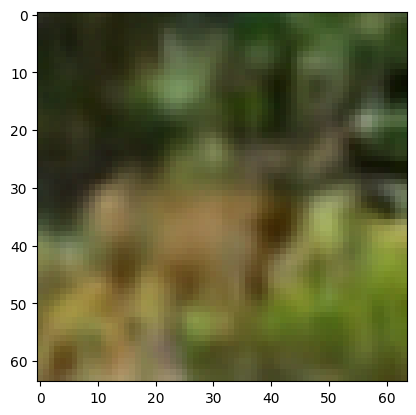

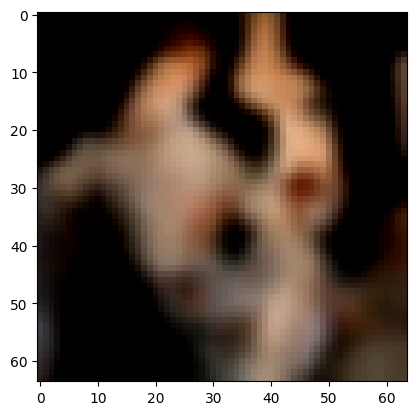

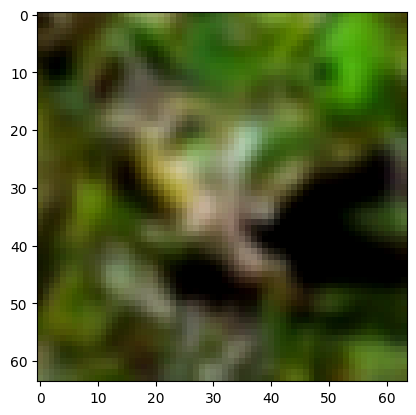

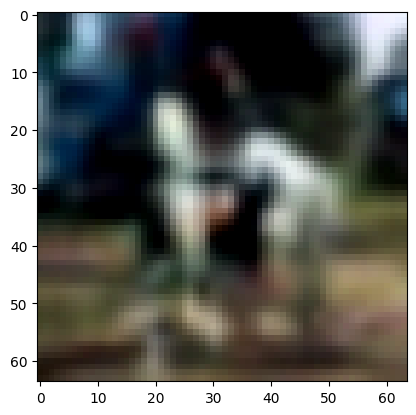

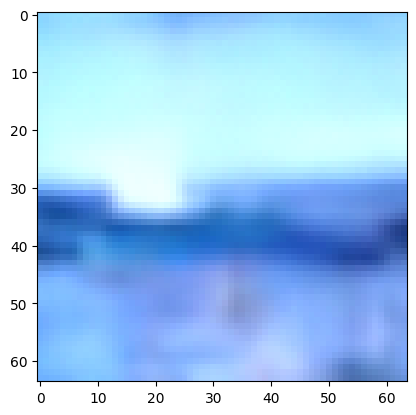

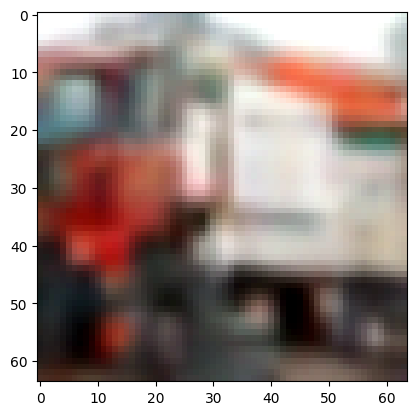

100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #51
Current learning rate is 0.00018747842136691685
Train Loss is: 0.009661892898380757


100%|█████████████████████████████████████████| 500/500 [35:08<00:00,  4.22s/it]


Epoch #52
Current learning rate is 0.0001857911155746146
Train Loss is: 0.00962301817536354


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #53
Current learning rate is 0.00018411899553444306
Train Loss is: 0.009582856413908302


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #54
Current learning rate is 0.00018246192457463308
Train Loss is: 0.00958098268415779


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #55
Current learning rate is 0.00018081976725346137
Train Loss is: 0.009699263028800488


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #56
Current learning rate is 0.00017919238934818022
Train Loss is: 0.009581764088012278


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #57
Current learning rate is 0.0001775796578440466
Train Loss is: 0.009659683829173446


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #58
Current learning rate is 0.00017598144092345017
Train Loss is: 0.009550593864172697


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #59
Current learning rate is 0.00017439760795513913
Train Loss is: 0.009606582426466047


100%|█████████████████████████████████████| 10000/10000 [12:13<00:00, 13.64it/s]


Epoch #60
Current learning rate is 0.00017282802948354286
Train Loss is: 0.009625037145800888
Valid Loss is: 0.009600713430353063


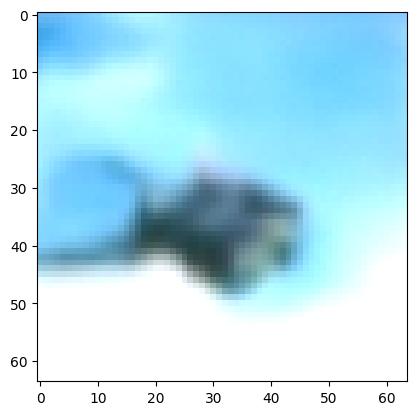

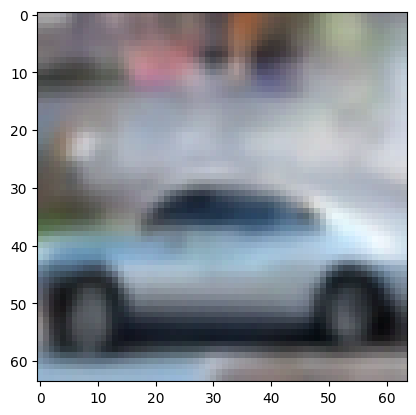

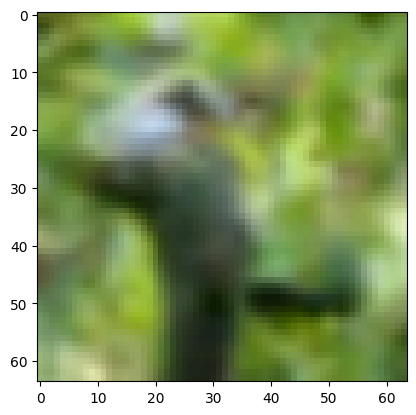

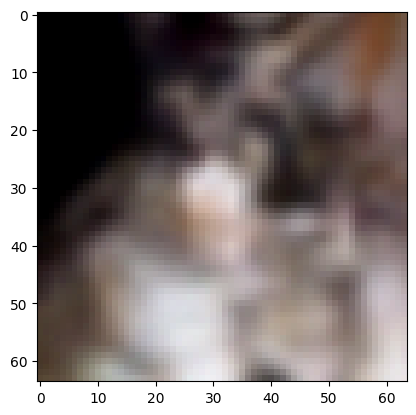

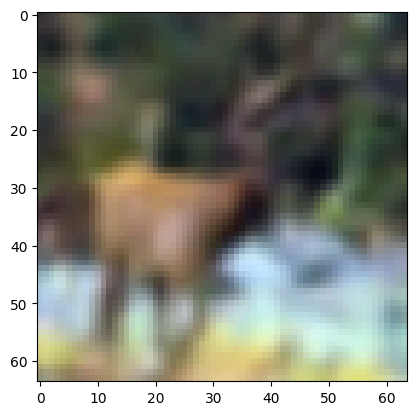

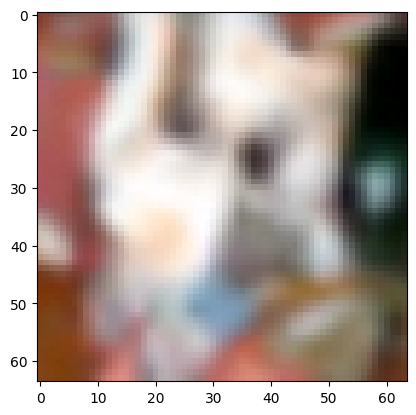

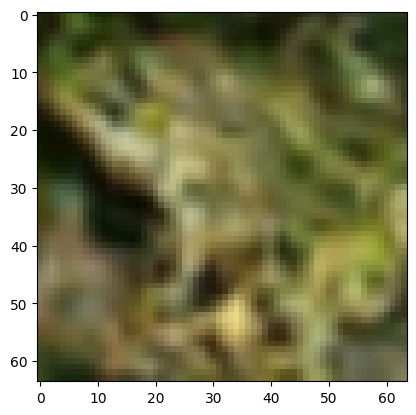

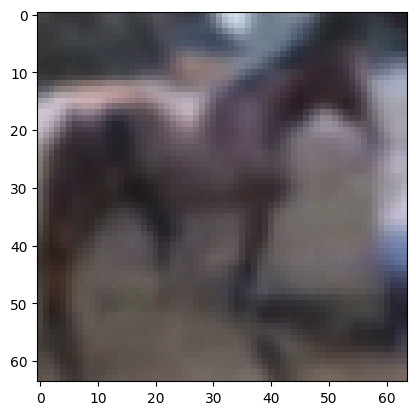

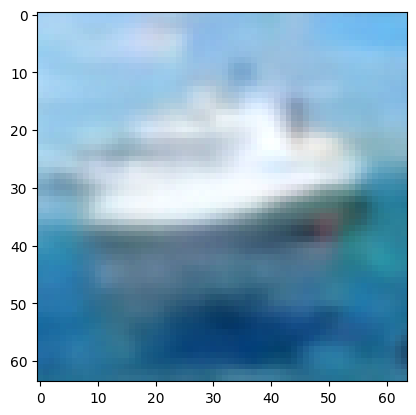

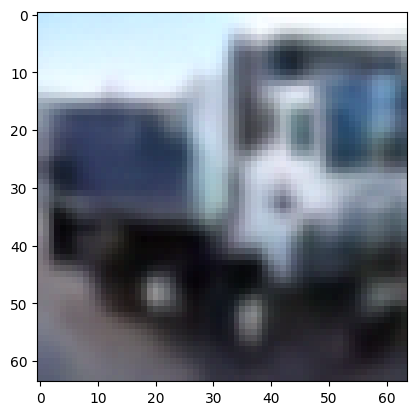

100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #61
Current learning rate is 0.00017127257721819098
Train Loss is: 0.00960912270192057


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #62
Current learning rate is 0.00016973112402322727
Train Loss is: 0.009602486046031117


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #63
Current learning rate is 0.0001682035439070182
Train Loss is: 0.00954108491819352


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #64
Current learning rate is 0.00016668971201185505
Train Loss is: 0.009580551971681416


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #65
Current learning rate is 0.00016518950460374835
Train Loss is: 0.009485863003879786


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #66
Current learning rate is 0.0001637027990623146
Train Loss is: 0.009496694184839725


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #67
Current learning rate is 0.00016222947387075376
Train Loss is: 0.009490191260352731


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #68
Current learning rate is 0.00016076940860591698
Train Loss is: 0.00960804757103324


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #69
Current learning rate is 0.00015932248392846372
Train Loss is: 0.009471781893633307


100%|█████████████████████████████████████| 10000/10000 [12:15<00:00, 13.60it/s]


Epoch #70
Current learning rate is 0.00015788858157310756
Train Loss is: 0.00957621518522501
Valid Loss is: 0.009295579374868612


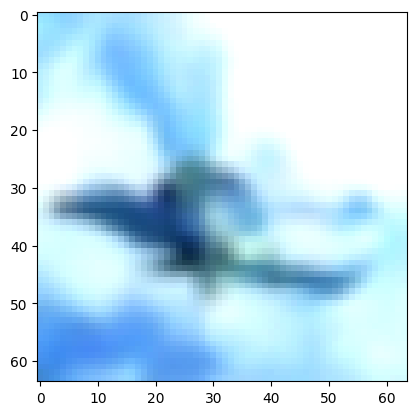

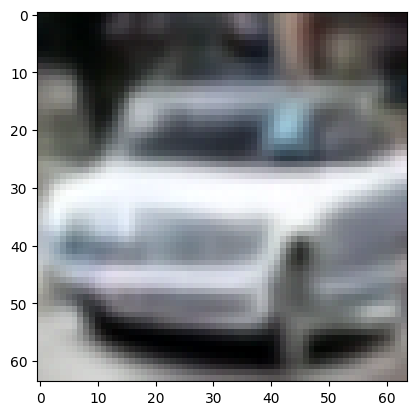

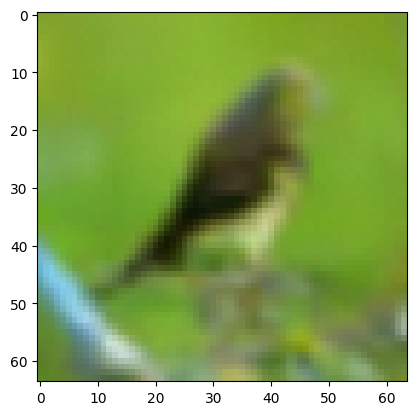

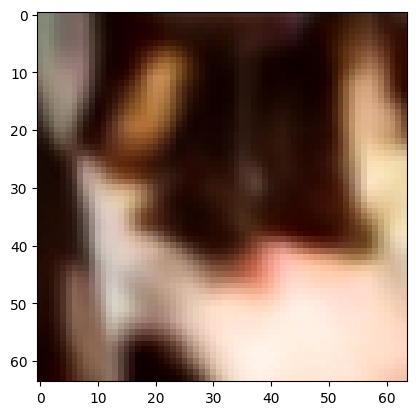

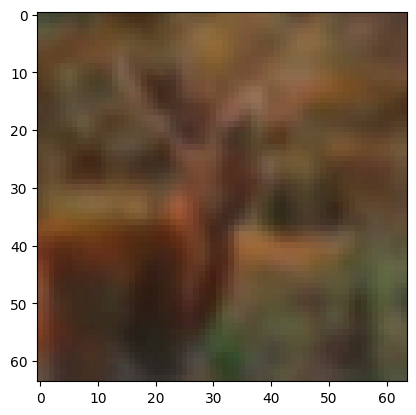

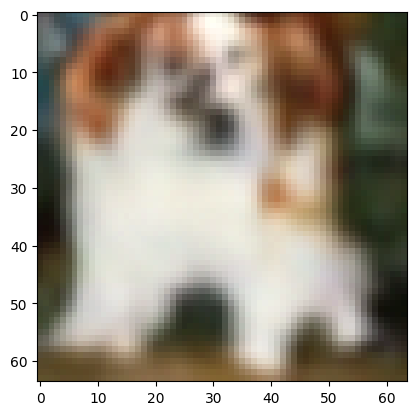

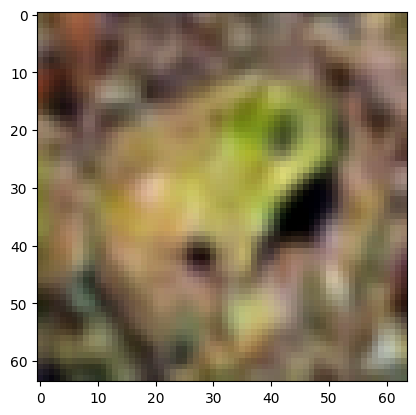

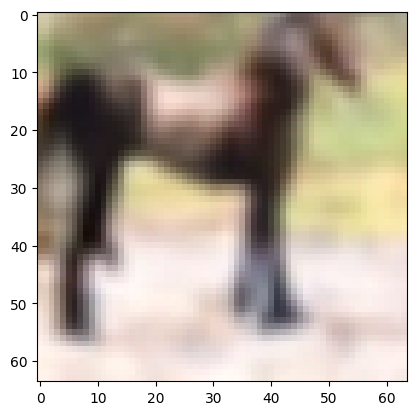

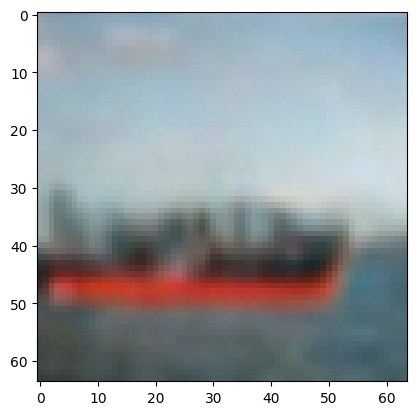

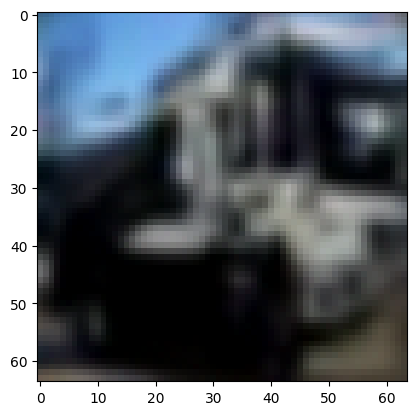

100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #71
Current learning rate is 0.0001564675843389496
Train Loss is: 0.009443327665328979


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #72
Current learning rate is 0.00015505937607989906
Train Loss is: 0.009411288617178798


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #73
Current learning rate is 0.00015366384169517995
Train Loss is: 0.009648438040167094


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #74
Current learning rate is 0.00015228086711992334
Train Loss is: 0.009580427802167833


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #75
Current learning rate is 0.00015091033931584403
Train Loss is: 0.009606087355874478


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #76
Current learning rate is 0.00014955214626200143
Train Loss is: 0.009542603079229594


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #77
Current learning rate is 0.00014820617694564342
Train Loss is: 0.00950592386815697


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #78
Current learning rate is 0.00014687232135313262
Train Loss is: 0.009603379014879464


100%|█████████████████████████████████████████| 500/500 [35:08<00:00,  4.22s/it]


Epoch #79
Current learning rate is 0.00014555047046095441
Train Loss is: 0.009456420985981822


100%|█████████████████████████████████████| 10000/10000 [12:15<00:00, 13.60it/s]


Epoch #80
Current learning rate is 0.0001442405162268058
Train Loss is: 0.009535697785206139
Valid Loss is: 0.009366619086729042


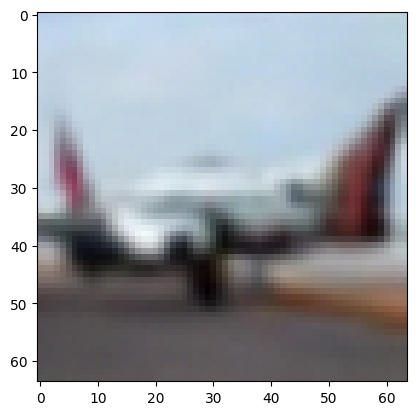

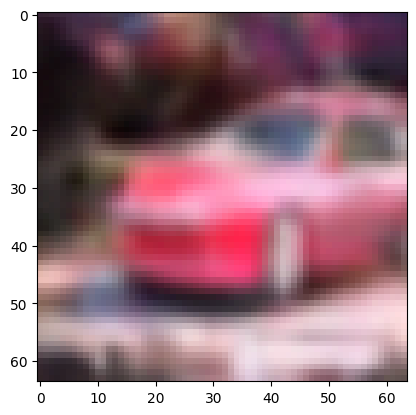

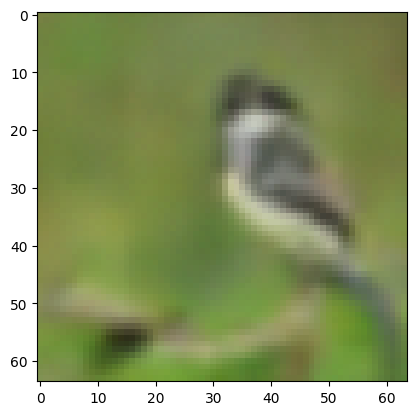

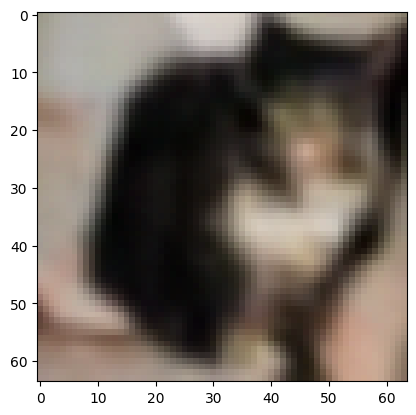

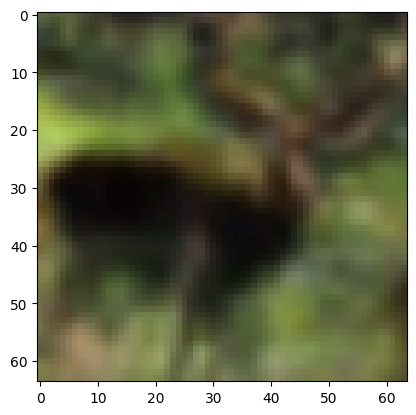

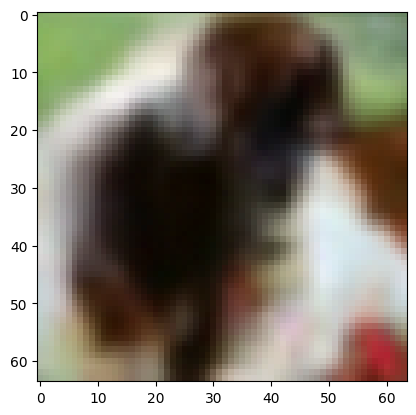

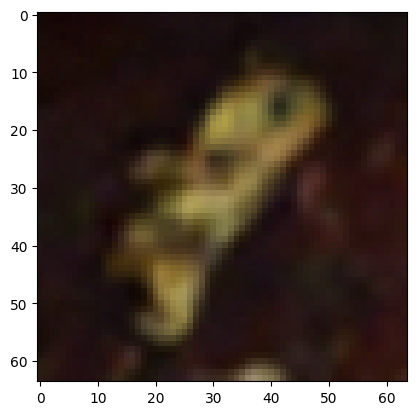

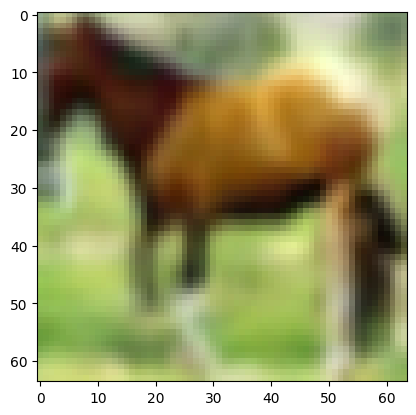

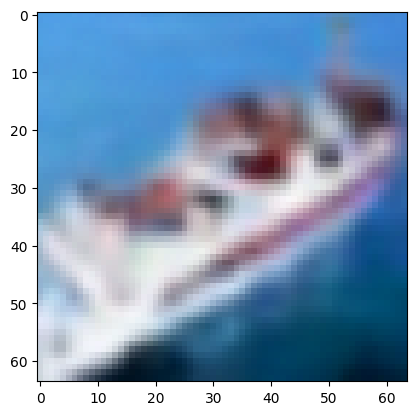

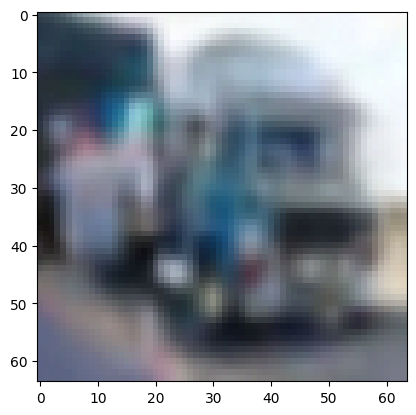

100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #81
Current learning rate is 0.00014294235158076457
Train Loss is: 0.009370655753649771


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #82
Current learning rate is 0.0001416558704165377
Train Loss is: 0.009435604143887758


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #83
Current learning rate is 0.00014038096758278886
Train Loss is: 0.00951518530305475


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #84
Current learning rate is 0.00013911753887454375
Train Loss is: 0.009417236465029418


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #85
Current learning rate is 0.00013786548102467285
Train Loss is: 0.009505103135481478


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #86
Current learning rate is 0.0001366246916954508
Train Loss is: 0.009467435203492641


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #87
Current learning rate is 0.00013539506947019174
Train Loss is: 0.009447147003374994


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #88
Current learning rate is 0.00013417651384496
Train Loss is: 0.009334703867323697


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #89
Current learning rate is 0.00013296892522035537
Train Loss is: 0.00954619740601629


100%|█████████████████████████████████████| 10000/10000 [12:17<00:00, 13.57it/s]


Epoch #90
Current learning rate is 0.00013177220489337218
Train Loss is: 0.009548015094362199
Valid Loss is: 0.009665766336695924


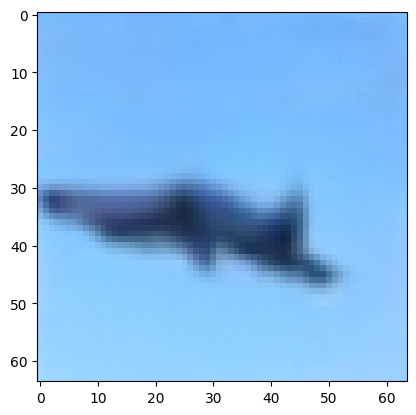

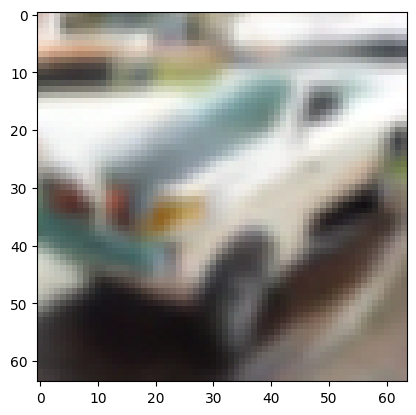

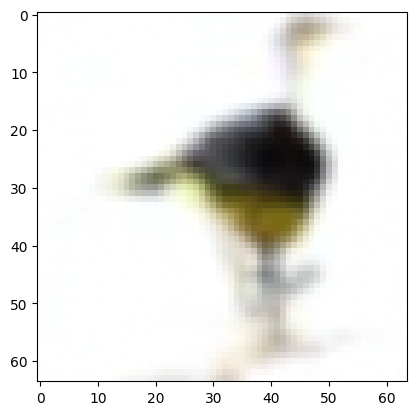

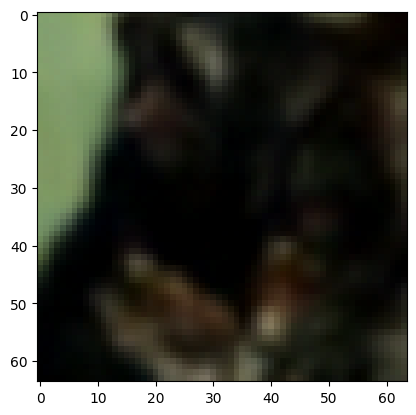

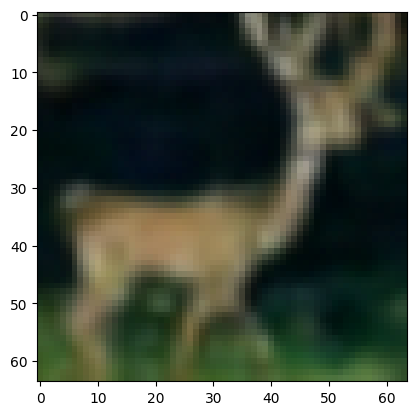

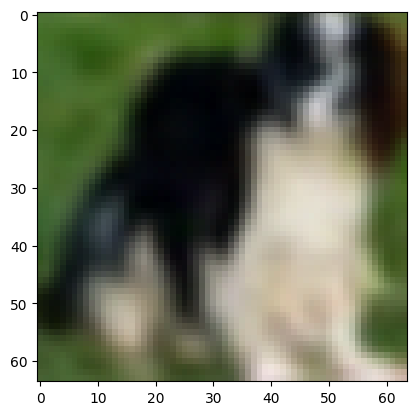

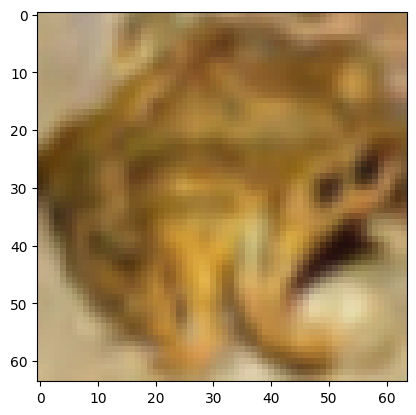

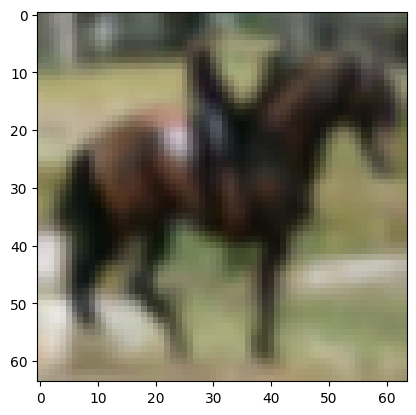

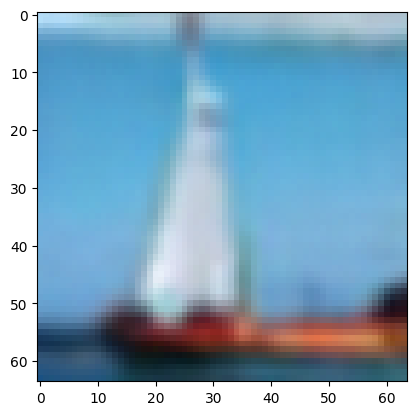

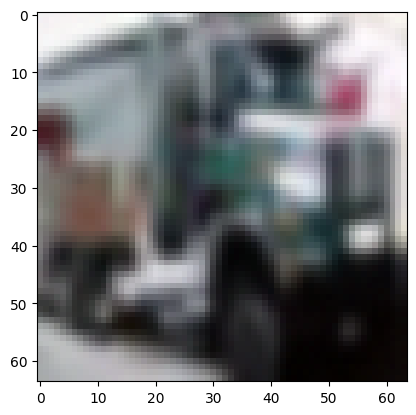

100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #91
Current learning rate is 0.00013058625504933183
Train Loss is: 0.00936873069126159


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #92
Current learning rate is 0.00012941097875388786
Train Loss is: 0.009517655326984823


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #93
Current learning rate is 0.00012824627994510287
Train Loss is: 0.00934884184692055


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #94
Current learning rate is 0.00012709206342559695
Train Loss is: 0.009399918305687606


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #95
Current learning rate is 0.00012594823485476657
Train Loss is: 0.009334863880649209


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #96
Current learning rate is 0.00012481470074107368
Train Loss is: 0.009285320492461323


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #97
Current learning rate is 0.00012369136843440402
Train Loss is: 0.009335686089470982


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #98
Current learning rate is 0.00012257814611849437
Train Loss is: 0.00934720539022237


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #99
Current learning rate is 0.00012147494280342792
Train Loss is: 0.009433708154596388


100%|█████████████████████████████████████| 10000/10000 [12:05<00:00, 13.79it/s]


Epoch #100
Current learning rate is 0.00012038166831819707
Train Loss is: 0.009227044863626362
Valid Loss is: 0.009404983491566418


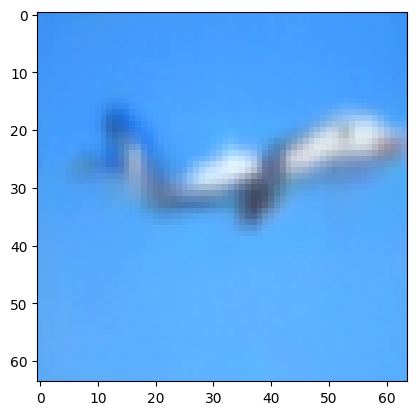

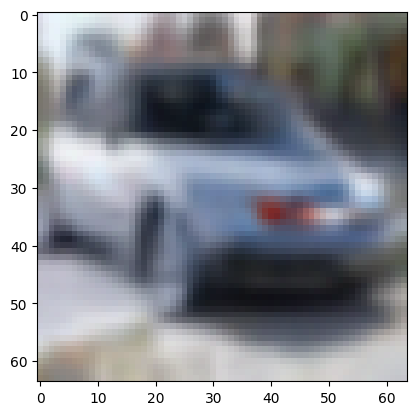

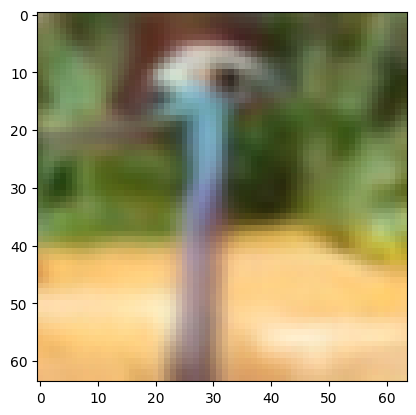

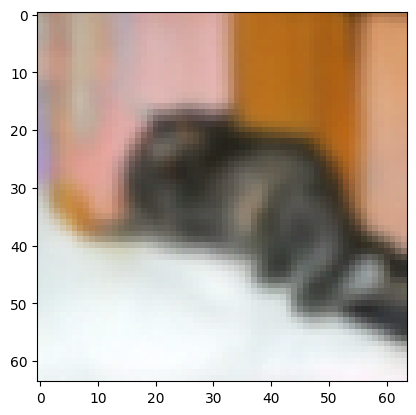

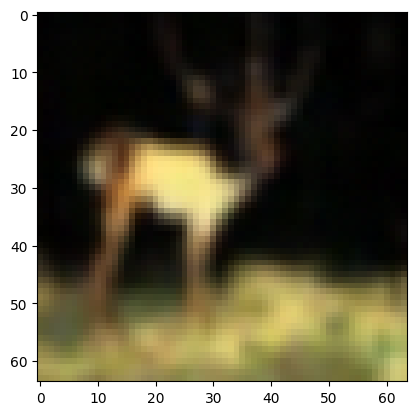

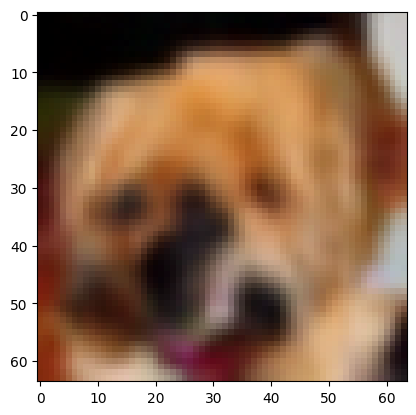

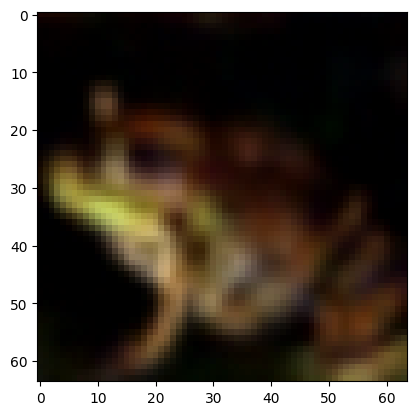

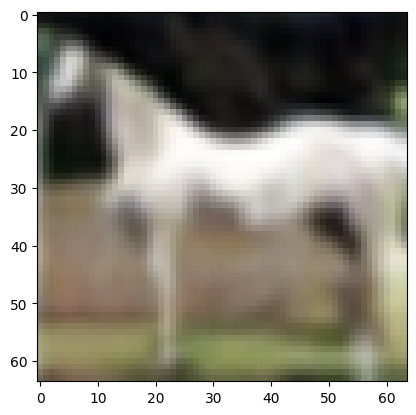

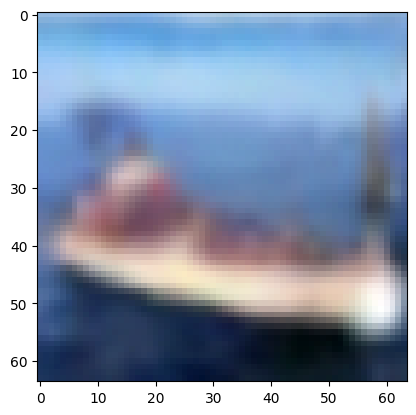

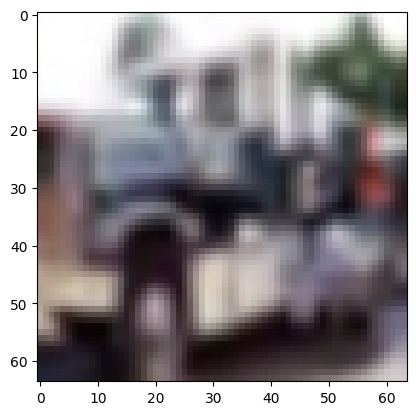

100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #101
Current learning rate is 0.0001192982333033333
Train Loss is: 0.009328966489061714


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #102
Current learning rate is 0.0001182245492036033
Train Loss is: 0.009300563542172314


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #103
Current learning rate is 0.00011716052826077087
Train Loss is: 0.009360277518630028


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #104
Current learning rate is 0.00011610608350642393
Train Loss is: 0.009432751392014325


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.22s/it]


Epoch #105
Current learning rate is 0.00011506112875486612
Train Loss is: 0.009518518026918173


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #106
Current learning rate is 0.00011402557859607232
Train Loss is: 0.009421264383941889


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #107
Current learning rate is 0.00011299934838870767
Train Loss is: 0.009406304852105677


100%|█████████████████████████████████████████| 500/500 [35:13<00:00,  4.23s/it]


Epoch #108
Current learning rate is 0.0001119823542532093
Train Loss is: 0.009228925057686865


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.23s/it]


Epoch #109
Current learning rate is 0.00011097451306493041
Train Loss is: 0.009449059697799385


100%|█████████████████████████████████████| 10000/10000 [12:16<00:00, 13.57it/s]


Epoch #110
Current learning rate is 0.00010997574244734604
Train Loss is: 0.009422060631215572
Valid Loss is: 0.009319124565255424


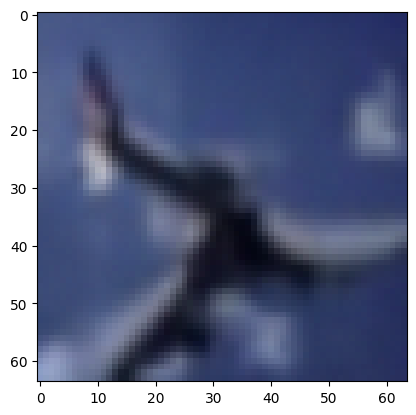

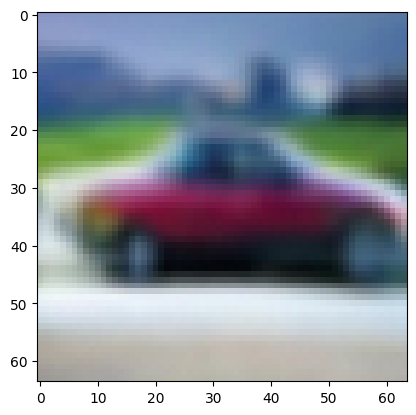

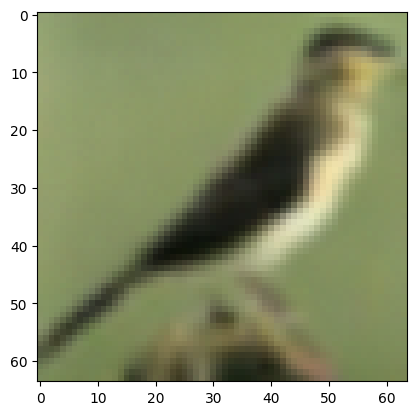

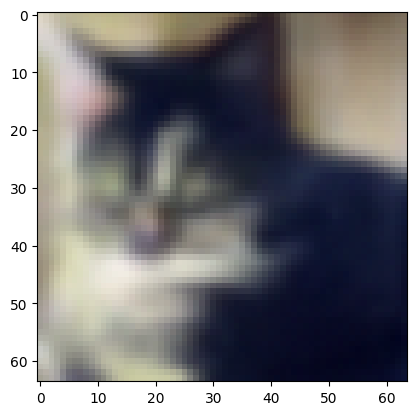

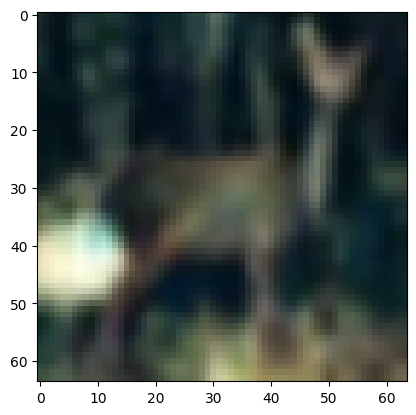

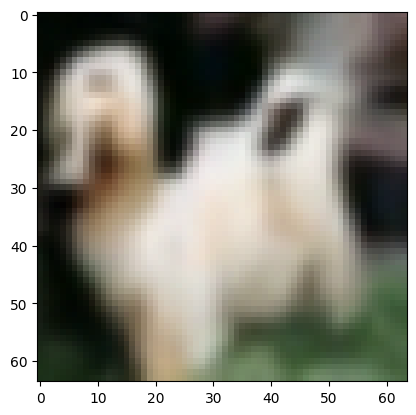

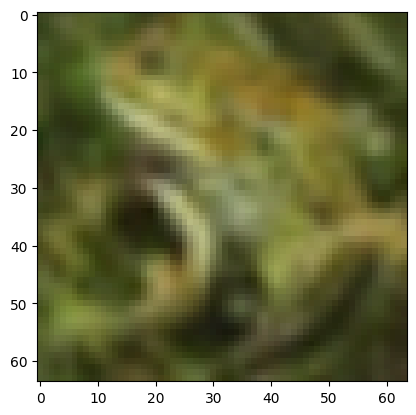

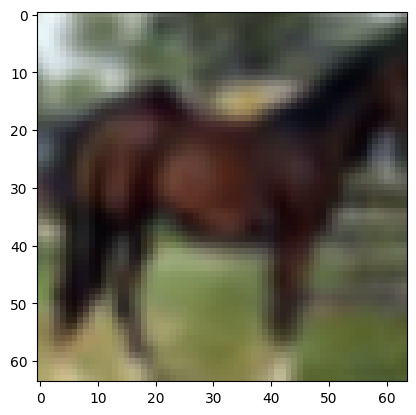

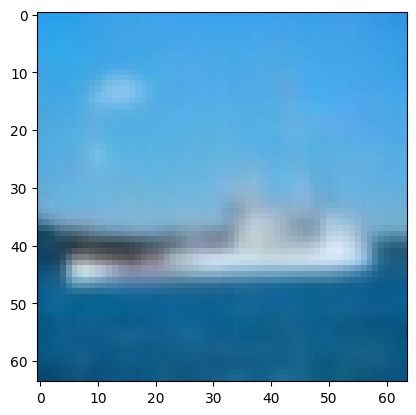

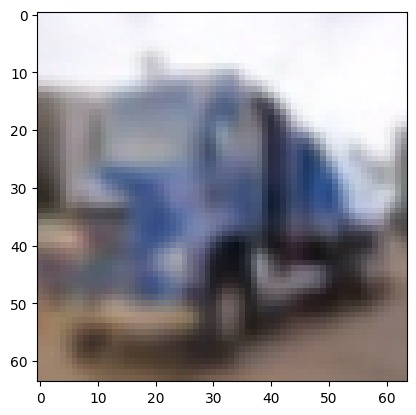

100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #111
Current learning rate is 0.00010898596076531992
Train Loss is: 0.009429437751881778


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #112
Current learning rate is 0.00010800508711843204
Train Loss is: 0.00931581879965961


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #113
Current learning rate is 0.00010703304133436615
Train Loss is: 0.009384945481084287


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #114
Current learning rate is 0.00010606974396235685
Train Loss is: 0.009462837487459182


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #115
Current learning rate is 0.00010511511626669564
Train Loss is: 0.009361064878292382


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #116
Current learning rate is 0.00010416908022029537
Train Loss is: 0.009358270758762955


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #117
Current learning rate is 0.00010323155849831272
Train Loss is: 0.009277716271579266


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #118
Current learning rate is 0.0001023024744718279
Train Loss is: 0.009301816388964653


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #119
Current learning rate is 0.00010138175220158144
Train Loss is: 0.00933802258130163


100%|█████████████████████████████████████| 10000/10000 [12:20<00:00, 13.51it/s]


Epoch #120
Current learning rate is 0.00010046931643176721
Train Loss is: 0.009428257763385772
Valid Loss is: 0.009573926226520597


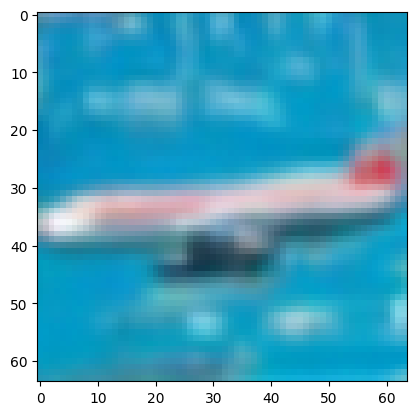

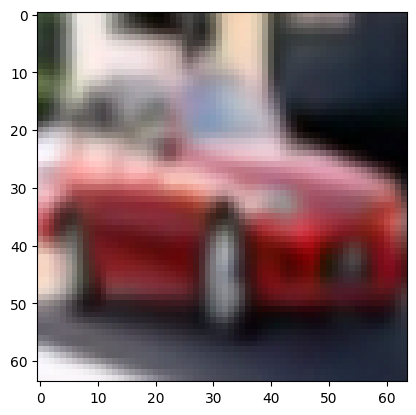

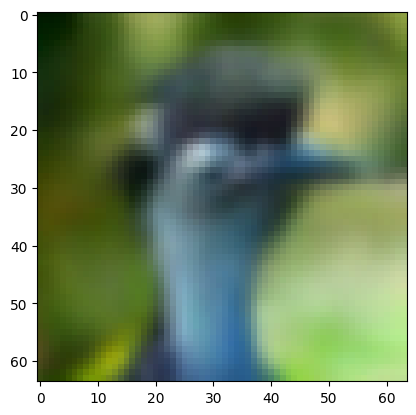

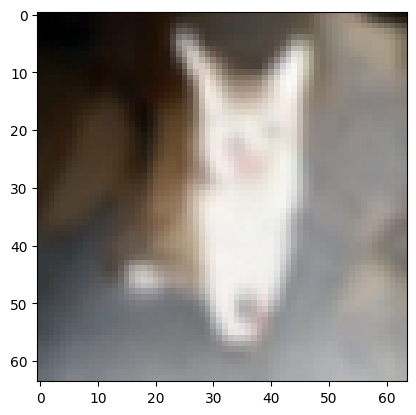

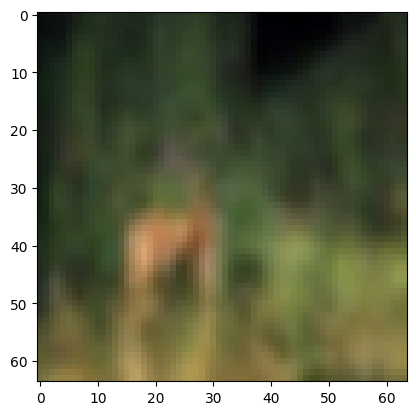

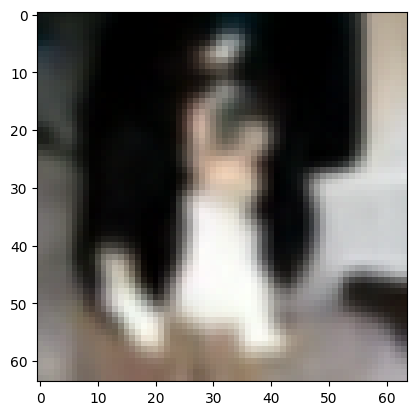

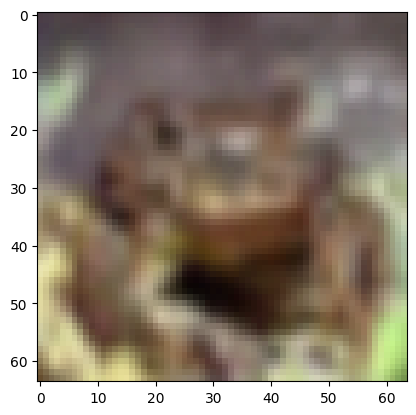

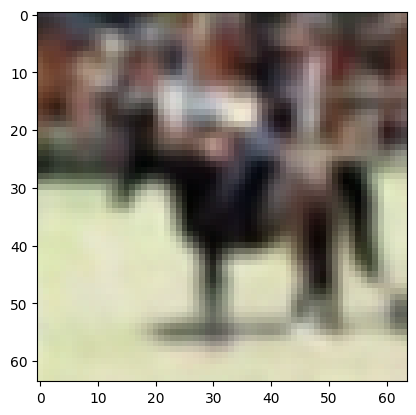

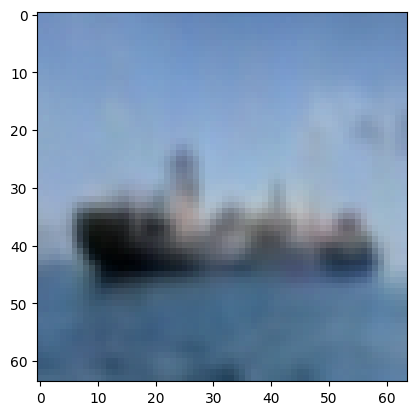

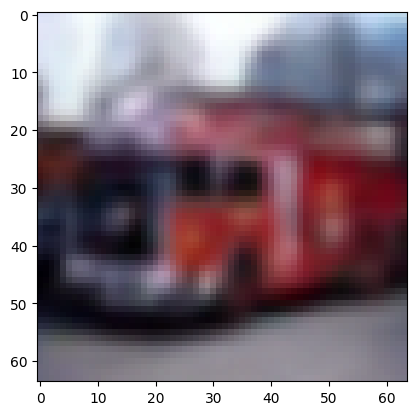

100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #121
Current learning rate is 9.95650925838813e-05
Train Loss is: 0.009237907824106514


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #122
Current learning rate is 9.866900675062637e-05
Train Loss is: 0.00920028965268284


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #123
Current learning rate is 9.778098568987074e-05
Train Loss is: 0.009319772338494658


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #124
Current learning rate is 9.69009568186619e-05
Train Loss is: 0.009298917988315225


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #125
Current learning rate is 9.602884820729394e-05
Train Loss is: 0.00936286508012563


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #126
Current learning rate is 9.516458857342829e-05
Train Loss is: 0.009462518106214702


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #127
Current learning rate is 9.430810727626744e-05
Train Loss is: 0.00929147591535002


100%|█████████████████████████████████████████| 500/500 [35:08<00:00,  4.22s/it]


Epoch #128
Current learning rate is 9.345933431078103e-05
Train Loss is: 0.009295116748660803


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #129
Current learning rate is 9.2618200301984e-05
Train Loss is: 0.009174128592945635


100%|█████████████████████████████████████| 10000/10000 [12:20<00:00, 13.50it/s]


Epoch #130
Current learning rate is 9.178463649926614e-05
Train Loss is: 0.009331233687698842
Valid Loss is: 0.00927144728546009


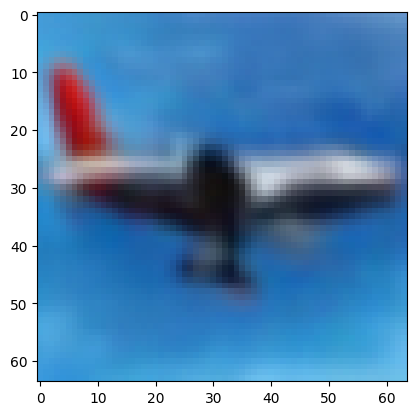

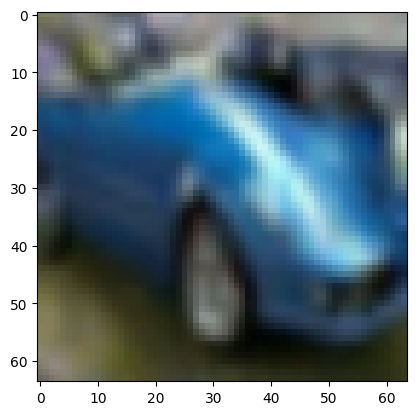

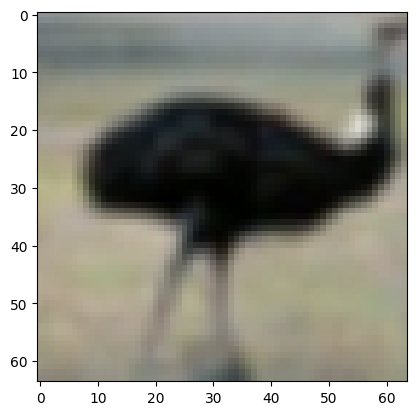

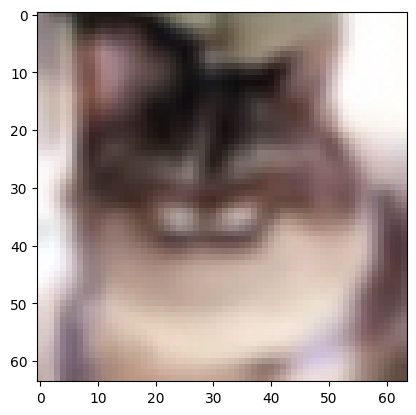

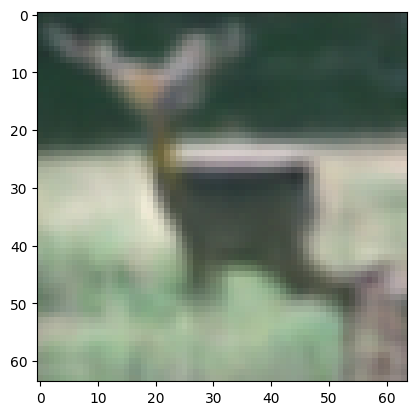

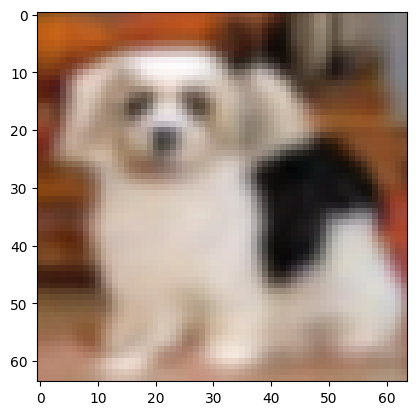

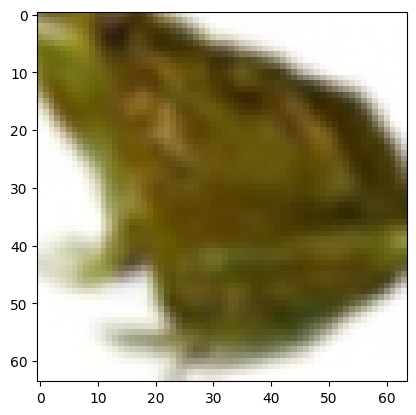

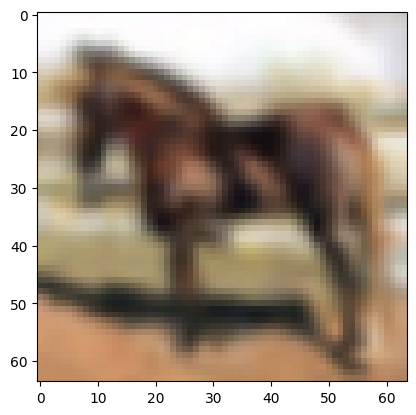

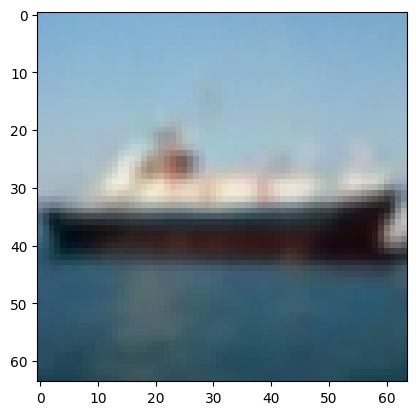

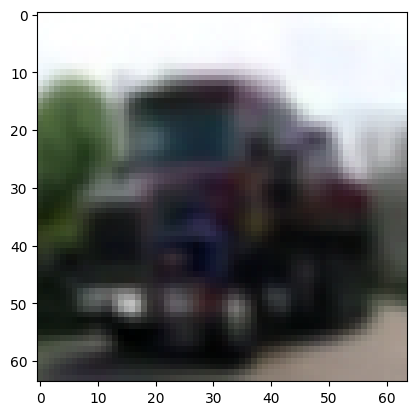

100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #131
Current learning rate is 9.095857477077274e-05
Train Loss is: 0.009251089920289814


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #132
Current learning rate is 9.013994759783578e-05
Train Loss is: 0.009310146311298013


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #133
Current learning rate is 8.932868806945526e-05
Train Loss is: 0.009275983231142162


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #134
Current learning rate is 8.852472987683017e-05
Train Loss is: 0.009219290230423212


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.22s/it]


Epoch #135
Current learning rate is 8.772800730793869e-05
Train Loss is: 0.009355705388821661


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #136
Current learning rate is 8.693845524216725e-05
Train Loss is: 0.009256711791269481


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #137
Current learning rate is 8.615600914498774e-05
Train Loss is: 0.009272058634087444


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #138
Current learning rate is 8.538060506268284e-05
Train Loss is: 0.00910544400382787


100%|█████████████████████████████████████████| 500/500 [35:08<00:00,  4.22s/it]


Epoch #139
Current learning rate is 8.46121796171187e-05
Train Loss is: 0.009386646878905594


100%|█████████████████████████████████████| 10000/10000 [12:19<00:00, 13.52it/s]


Epoch #140
Current learning rate is 8.385067000056464e-05
Train Loss is: 0.009316241238266229
Valid Loss is: 0.009593717899437524


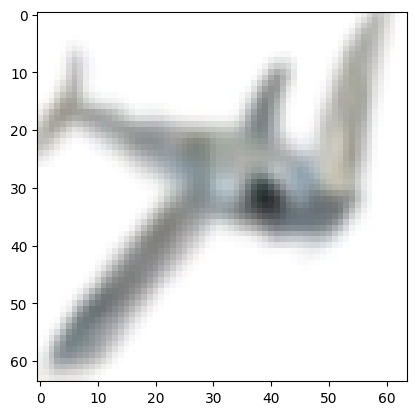

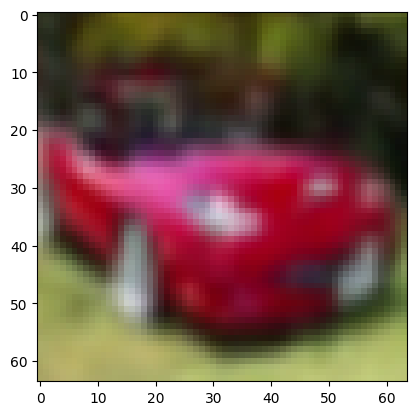

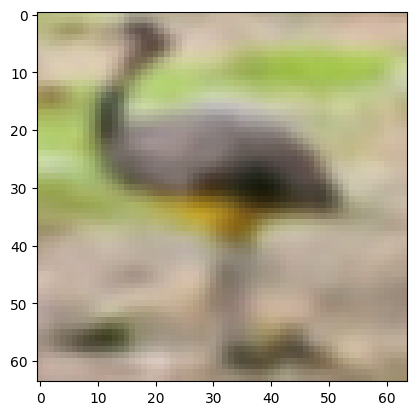

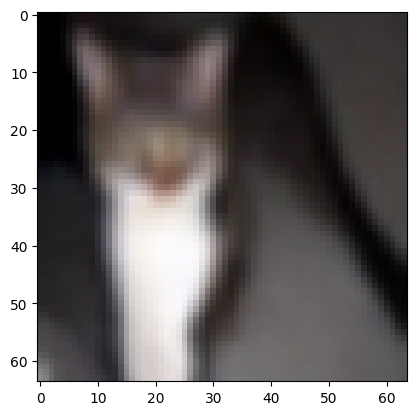

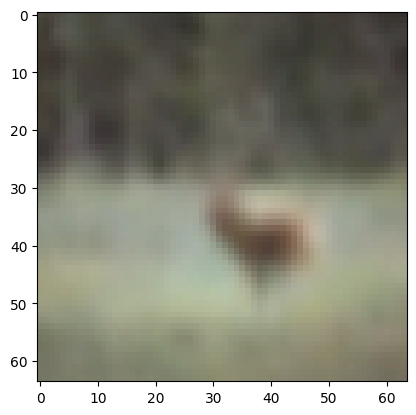

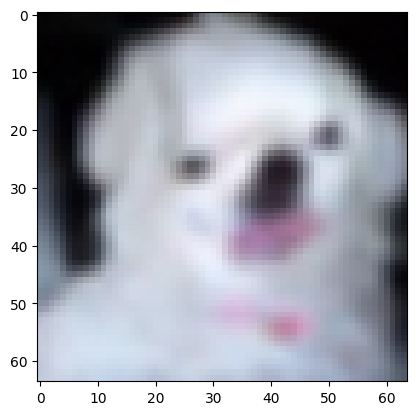

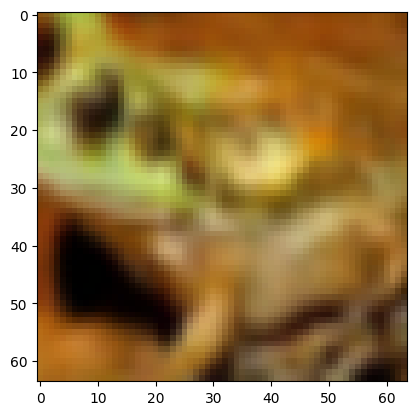

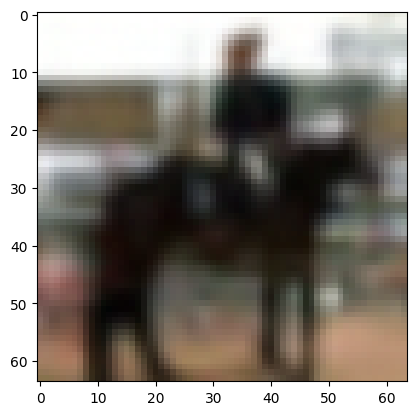

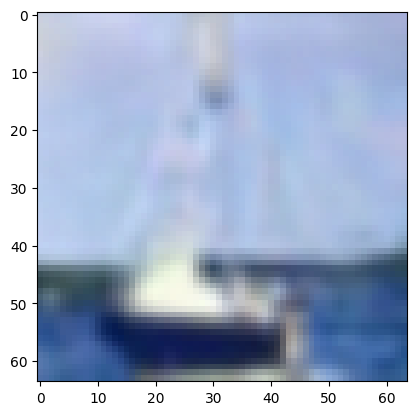

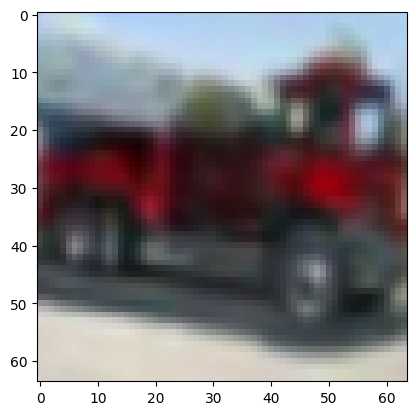

100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #141
Current learning rate is 8.309601397055955e-05
Train Loss is: 0.009354008376598359


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #142
Current learning rate is 8.234814984482451e-05
Train Loss is: 0.009191417560912669


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #143
Current learning rate is 8.160701649622109e-05
Train Loss is: 0.009194168419577181


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #144
Current learning rate is 8.08725533477551e-05
Train Loss is: 0.009236782193183898


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #145
Current learning rate is 8.01447003676253e-05
Train Loss is: 0.009325025682337583


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #146
Current learning rate is 7.942339806431667e-05
Train Loss is: 0.0091806730190292


100%|█████████████████████████████████████████| 500/500 [35:14<00:00,  4.23s/it]


Epoch #147
Current learning rate is 7.870858748173782e-05
Train Loss is: 0.009142030690796674


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.22s/it]


Epoch #148
Current learning rate is 7.800021019440218e-05
Train Loss is: 0.009287321329116822


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.22s/it]


Epoch #149
Current learning rate is 7.729820830265256e-05
Train Loss is: 0.00924335163179785


100%|█████████████████████████████████████| 10000/10000 [12:23<00:00, 13.44it/s]


Epoch #150
Current learning rate is 7.660252442792868e-05
Train Loss is: 0.009239409665577113
Valid Loss is: 0.009473834357446413


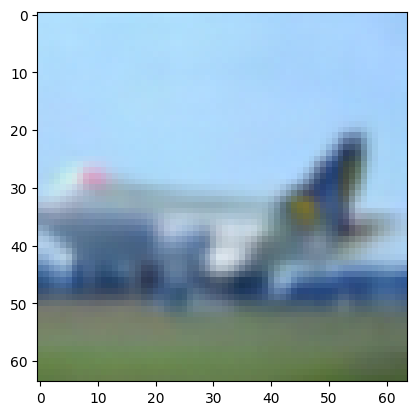

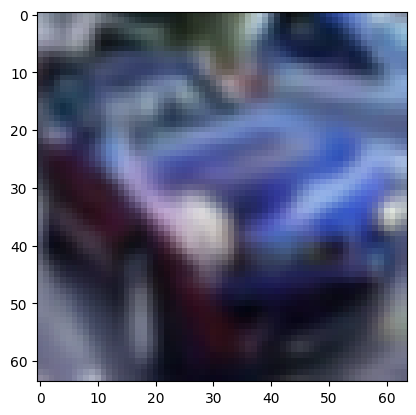

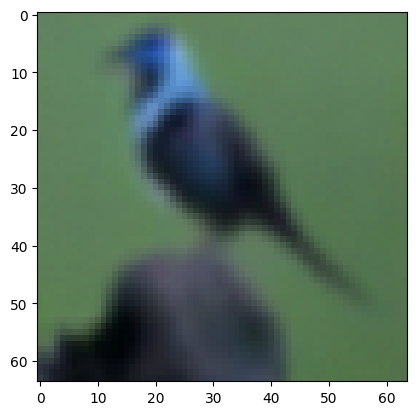

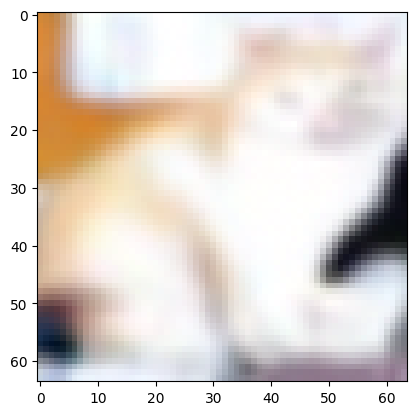

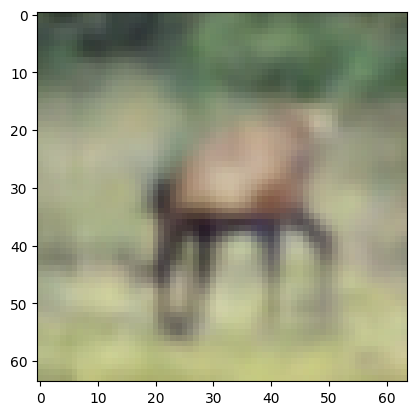

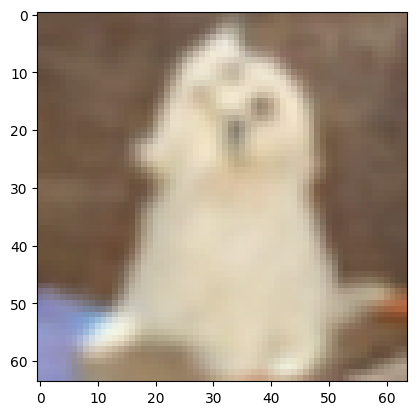

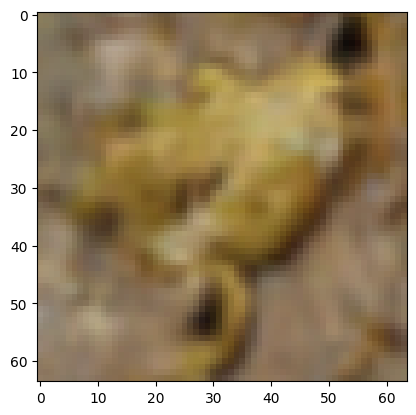

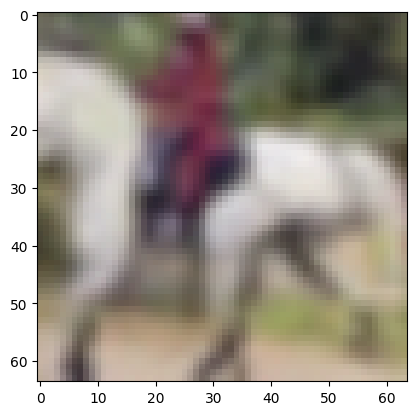

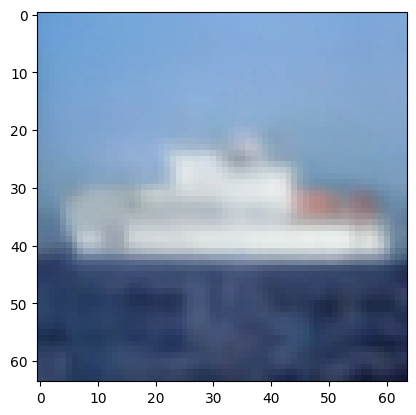

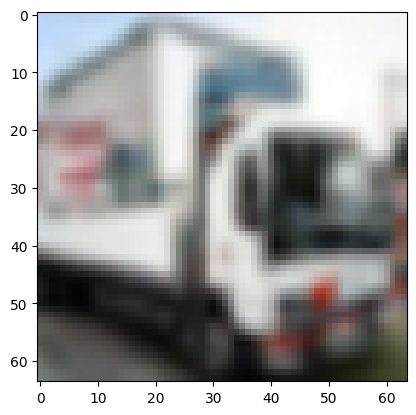

100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #151
Current learning rate is 7.591310170807732e-05
Train Loss is: 0.009321973087266087


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #152
Current learning rate is 7.522988379270462e-05
Train Loss is: 0.00919973675813526


100%|█████████████████████████████████████████| 500/500 [35:08<00:00,  4.22s/it]


Epoch #153
Current learning rate is 7.455281483857028e-05
Train Loss is: 0.009331582815386355


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #154
Current learning rate is 7.388183950502315e-05
Train Loss is: 0.0093110220329836


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #155
Current learning rate is 7.321690294947794e-05
Train Loss is: 0.009204327817074955


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #156
Current learning rate is 7.255795082293264e-05
Train Loss is: 0.009256243497133256


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.22s/it]


Epoch #157
Current learning rate is 7.190492926552624e-05
Train Loss is: 0.009300876706838608


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #158
Current learning rate is 7.12577849021365e-05
Train Loss is: 0.009200506023131312


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #159
Current learning rate is 7.061646483801727e-05
Train Loss is: 0.009270119158551096


100%|█████████████████████████████████████| 10000/10000 [12:22<00:00, 13.48it/s]


Epoch #160
Current learning rate is 6.998091665447511e-05
Train Loss is: 0.009049709710292519
Valid Loss is: 0.009256624850735262


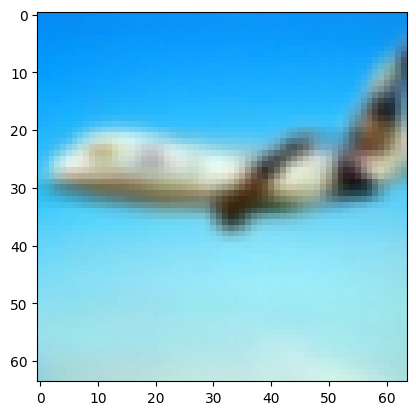

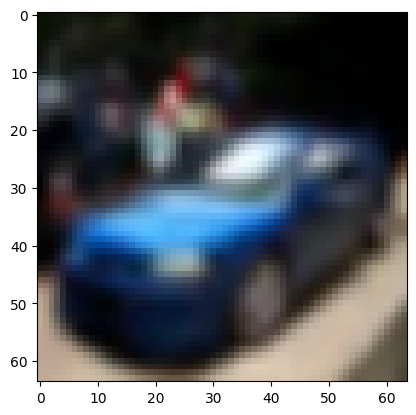

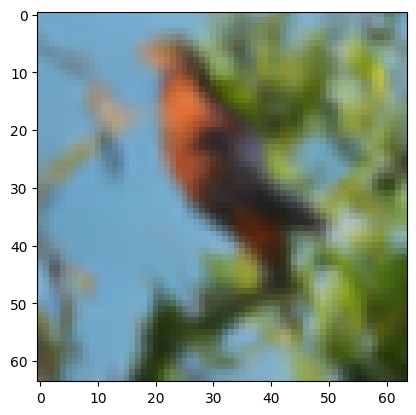

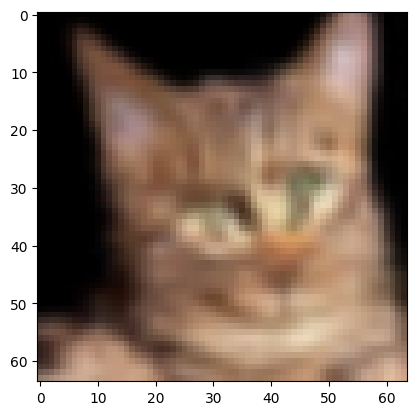

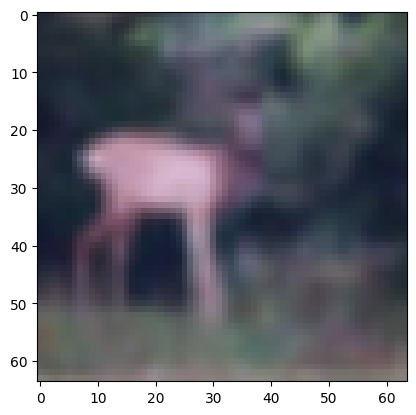

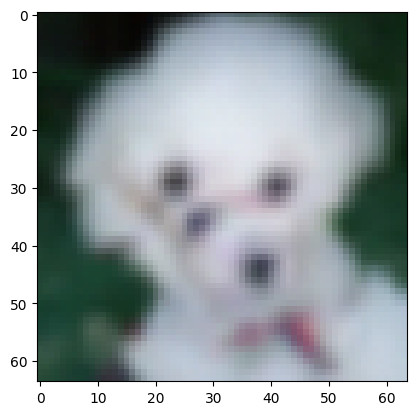

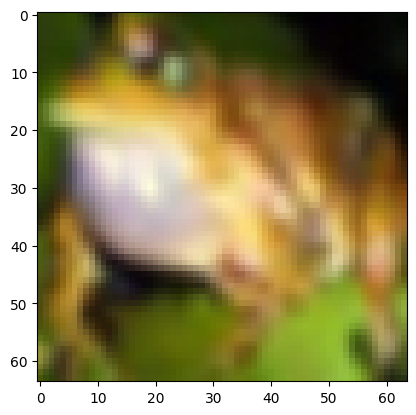

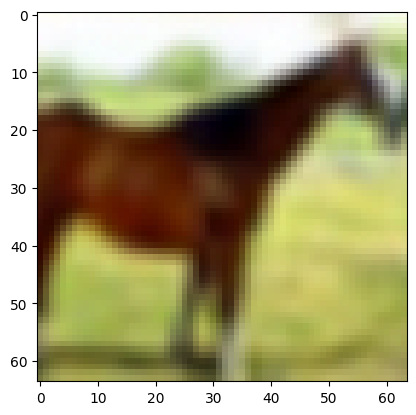

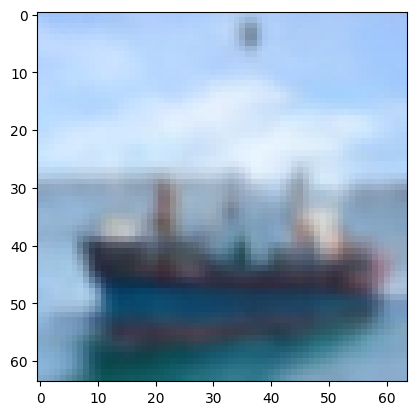

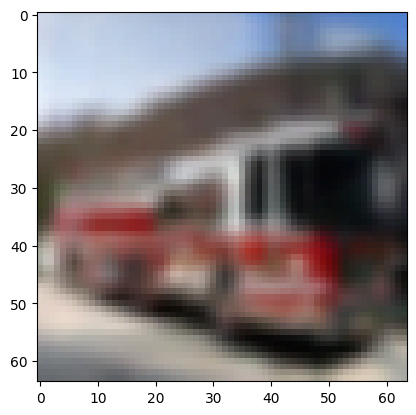

100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #161
Current learning rate is 6.935108840458483e-05
Train Loss is: 0.009045497762039304


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #162
Current learning rate is 6.872692860894357e-05
Train Loss is: 0.009331398835405708


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #163
Current learning rate is 6.810838625146308e-05
Train Loss is: 0.009235768280923366


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #164
Current learning rate is 6.749541077519991e-05
Train Loss is: 0.009175780422985554


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #165
Current learning rate is 6.688795207822312e-05
Train Loss is: 0.00915481333900243


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #166
Current learning rate is 6.628596050951911e-05
Train Loss is: 0.009175284888595342


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #167
Current learning rate is 6.568938686493344e-05
Train Loss is: 0.00907635127659887


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #168
Current learning rate is 6.509818238314904e-05
Train Loss is: 0.00913544711470604


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #169
Current learning rate is 6.45122987417007e-05
Train Loss is: 0.009187621141783894


100%|█████████████████████████████████████| 10000/10000 [12:23<00:00, 13.45it/s]


Epoch #170
Current learning rate is 6.393168805302538e-05
Train Loss is: 0.009213187292218209
Valid Loss is: 0.009425587446066312


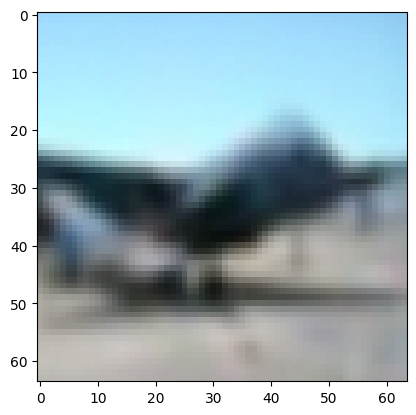

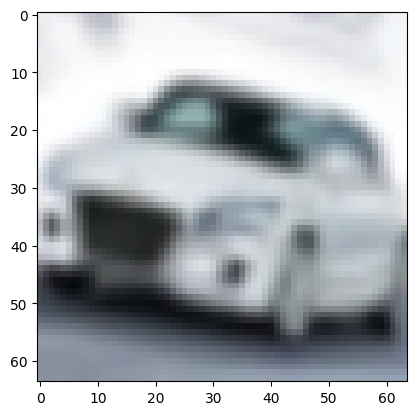

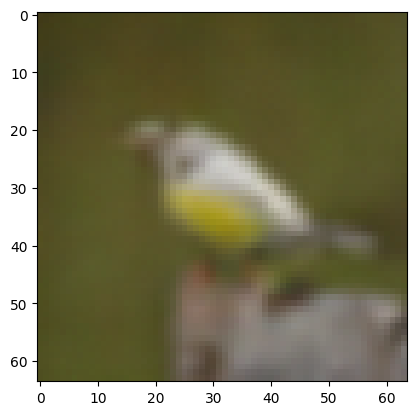

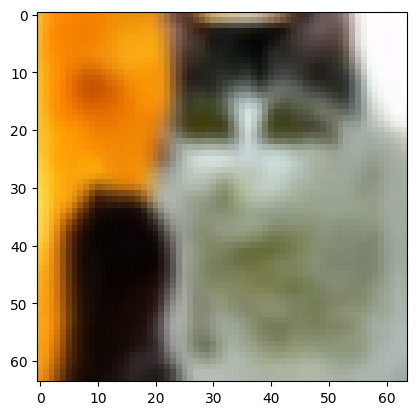

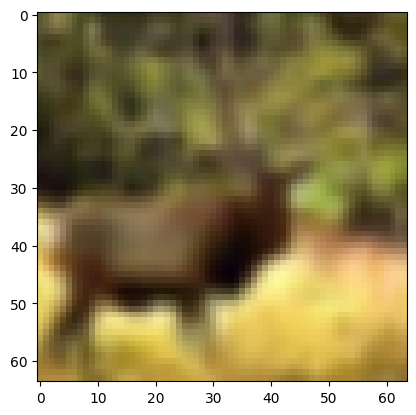

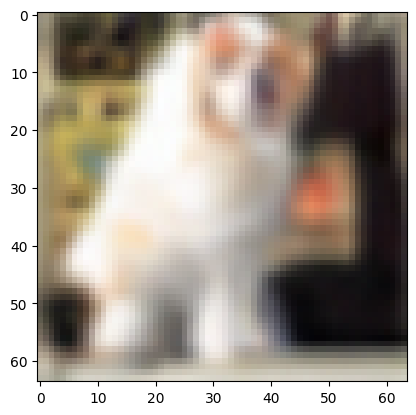

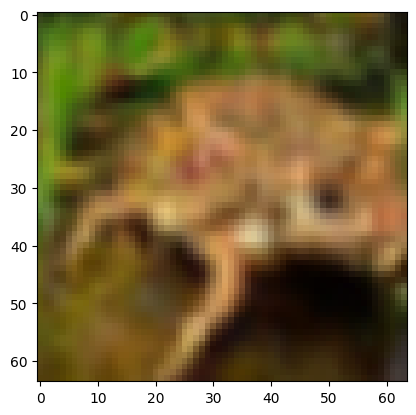

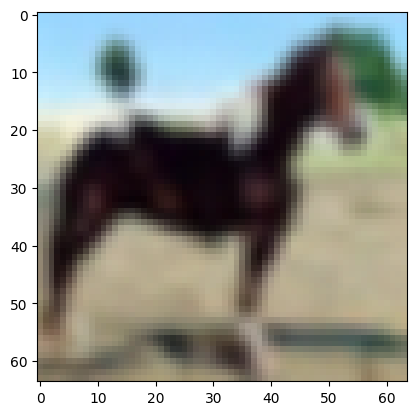

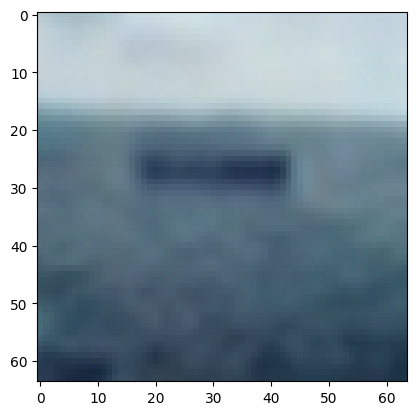

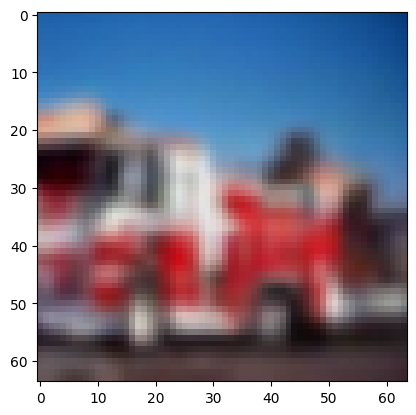

100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #171
Current learning rate is 6.335630286054816e-05
Train Loss is: 0.009164389134384691


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #172
Current learning rate is 6.278609613480322e-05
Train Loss is: 0.009175185144878924


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #173
Current learning rate is 6.222102126959e-05
Train Loss is: 0.009110259277746082


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #174
Current learning rate is 6.166103207816368e-05
Train Loss is: 0.009246154758147895


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #175
Current learning rate is 6.11060827894602e-05
Train Loss is: 0.009384478914551436


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #176
Current learning rate is 6.055612804435506e-05
Train Loss is: 0.009162472845055163


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #177
Current learning rate is 6.001112289195587e-05
Train Loss is: 0.0092383206570521


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #178
Current learning rate is 5.947102278592826e-05
Train Loss is: 0.009238347458653153


100%|█████████████████████████████████████████| 500/500 [35:07<00:00,  4.21s/it]


Epoch #179
Current learning rate is 5.893578358085491e-05
Train Loss is: 0.009294591007754207


100%|█████████████████████████████████████| 10000/10000 [12:23<00:00, 13.45it/s]


Epoch #180
Current learning rate is 5.840536152862721e-05
Train Loss is: 0.009161289940588176
Valid Loss is: 0.008859076945468223


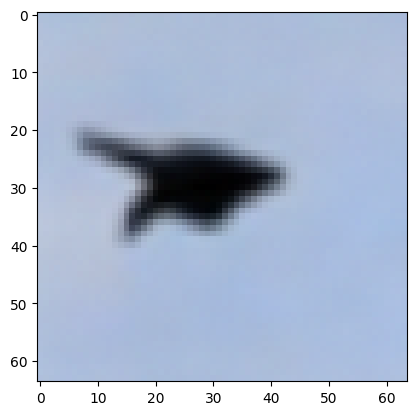

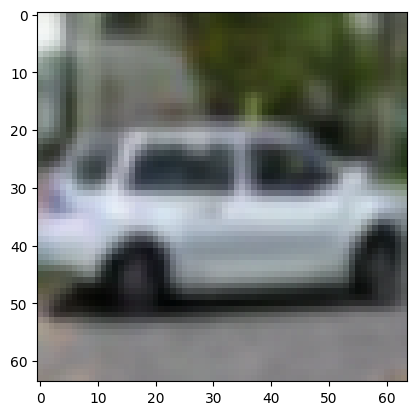

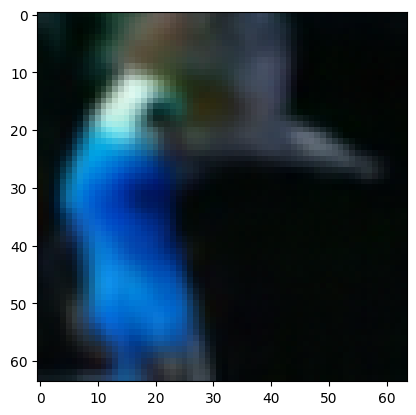

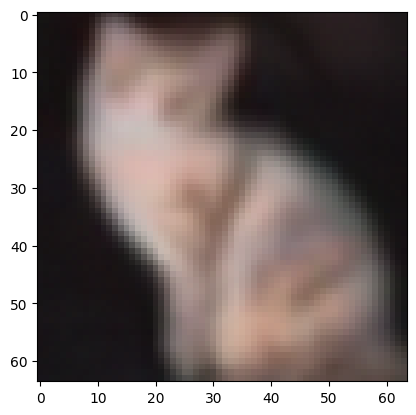

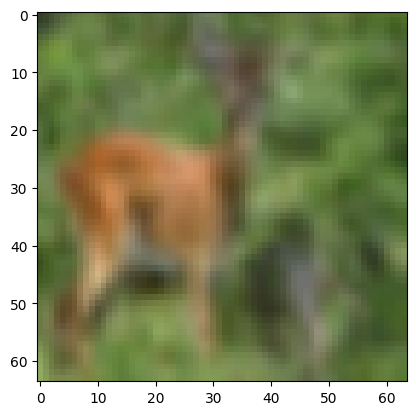

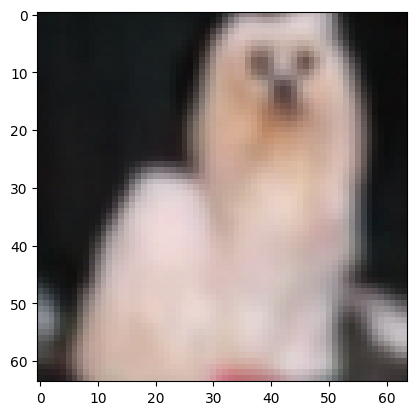

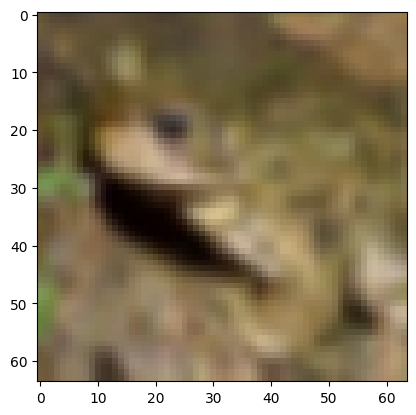

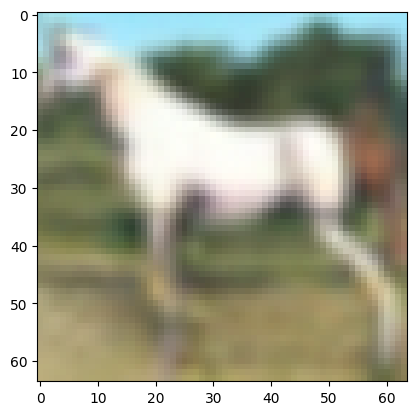

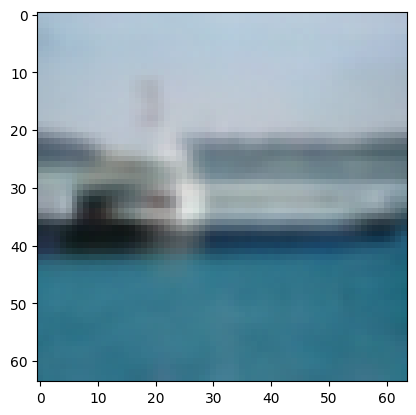

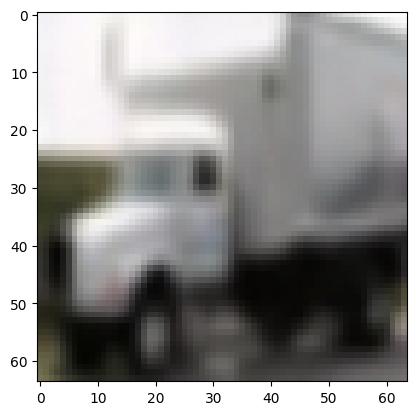

100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #181
Current learning rate is 5.787971327486957e-05
Train Loss is: 0.009040789207443596


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #182
Current learning rate is 5.735879585539574e-05
Train Loss is: 0.00925585102941841


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #183
Current learning rate is 5.684256669269718e-05
Train Loss is: 0.009125156230293214


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #184
Current learning rate is 5.63309835924629e-05
Train Loss is: 0.009111813719384371


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #185
Current learning rate is 5.582400474013073e-05
Train Loss is: 0.009135137552395462


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #186
Current learning rate is 5.532158869746956e-05
Train Loss is: 0.009135795032605528


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #187
Current learning rate is 5.482369439919233e-05
Train Loss is: 0.009107281419448554


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #188
Current learning rate is 5.43302811495996e-05
Train Loss is: 0.009134588004089892


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #189
Current learning rate is 5.38413086192532e-05
Train Loss is: 0.009244928547181189


100%|█████████████████████████████████████| 10000/10000 [12:23<00:00, 13.45it/s]


Epoch #190
Current learning rate is 5.3356736841679925e-05
Train Loss is: 0.009181210248731076
Valid Loss is: 0.009234587789698344


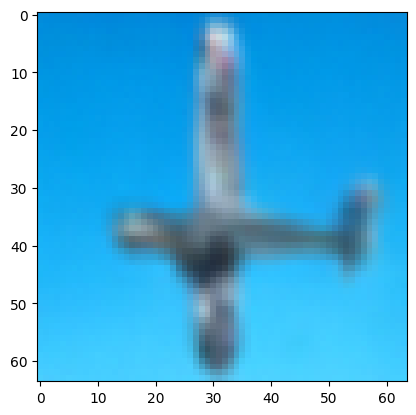

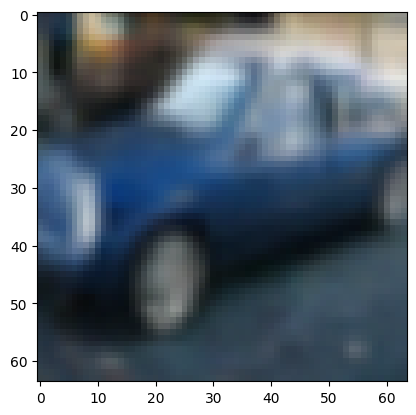

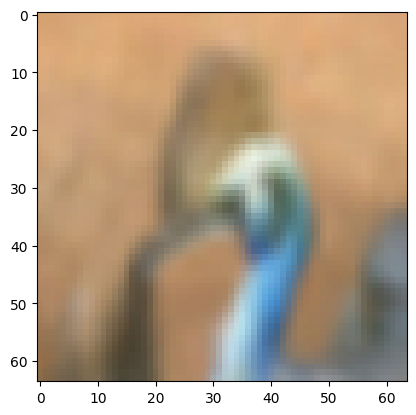

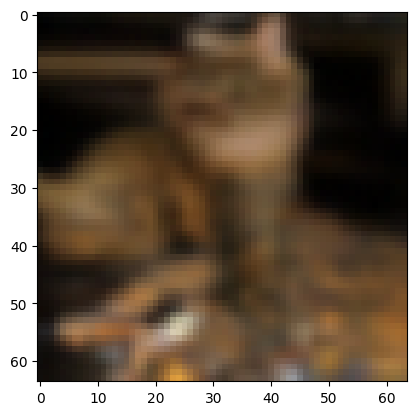

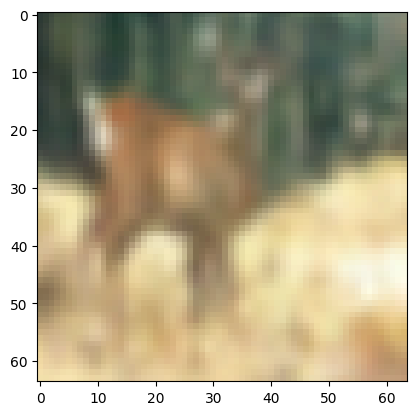

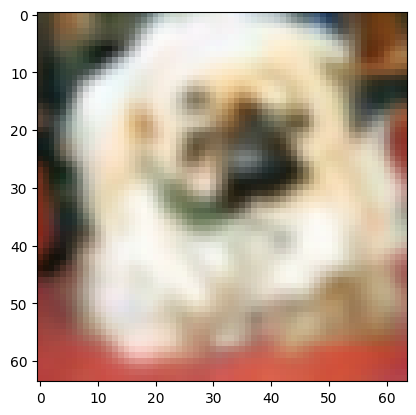

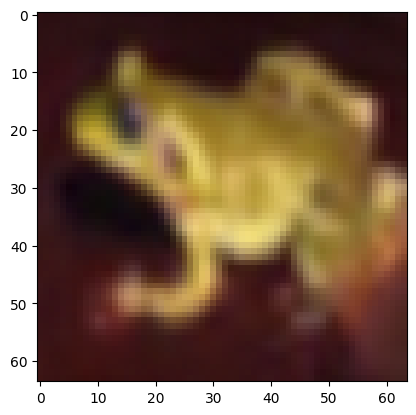

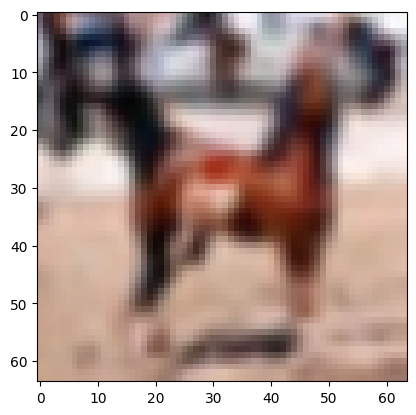

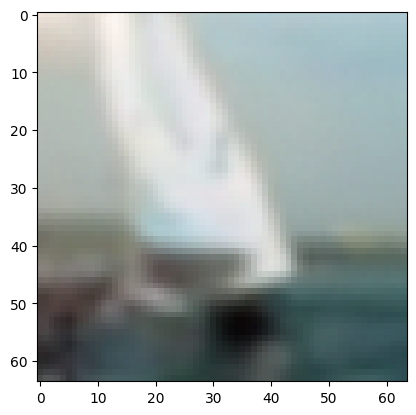

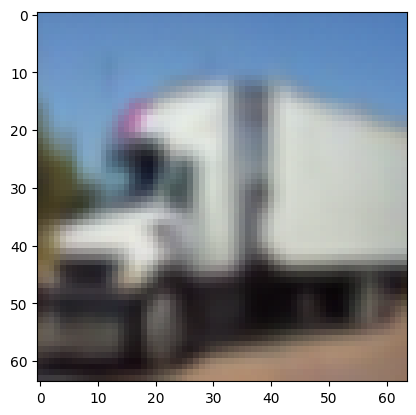

100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #191
Current learning rate is 5.287652621010481e-05
Train Loss is: 0.009142388701438903


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #192
Current learning rate is 5.2400637474213864e-05
Train Loss is: 0.009184876982122659


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #193
Current learning rate is 5.192903173694594e-05
Train Loss is: 0.009036217167042195


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #194
Current learning rate is 5.1461670451313425e-05
Train Loss is: 0.009077273201197385


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #195
Current learning rate is 5.0998515417251605e-05
Train Loss is: 0.009175174102187158


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #196
Current learning rate is 5.053952877849634e-05
Train Loss is: 0.00906153736077249


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #197
Current learning rate is 5.0084673019489874e-05
Train Loss is: 0.009157136977650224


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #198
Current learning rate is 4.963391096231446e-05
Train Loss is: 0.009248508313670755


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #199
Current learning rate is 4.9187205763653635e-05
Train Loss is: 0.009345696883276106


100%|█████████████████████████████████████| 10000/10000 [12:24<00:00, 13.44it/s]


Epoch #200
Current learning rate is 4.874452091178075e-05
Train Loss is: 0.00914472336601466
Valid Loss is: 0.009391082168216144


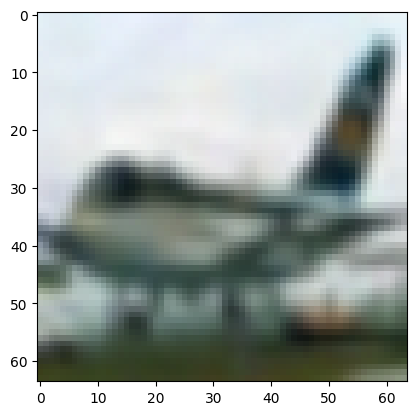

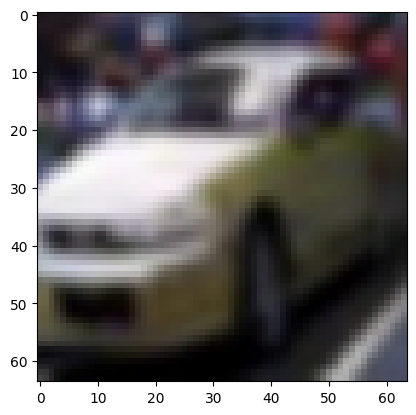

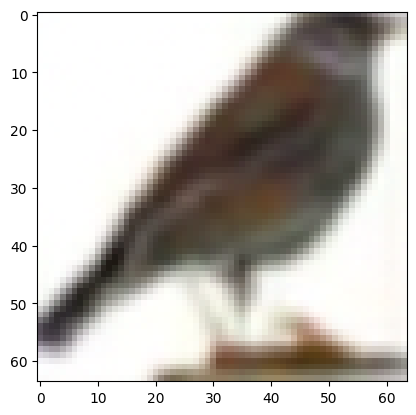

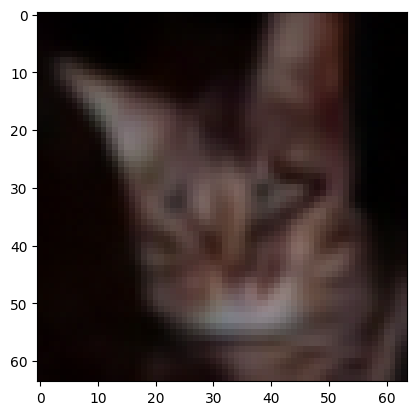

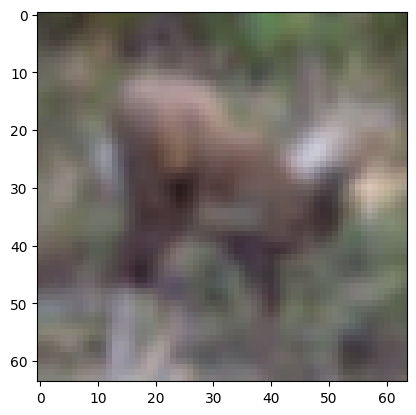

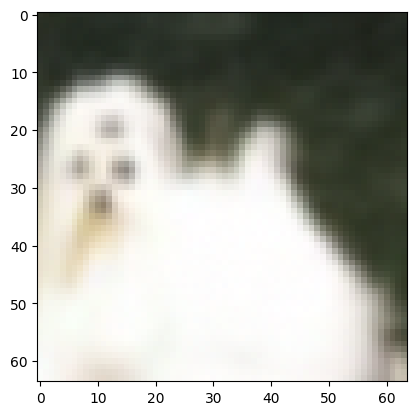

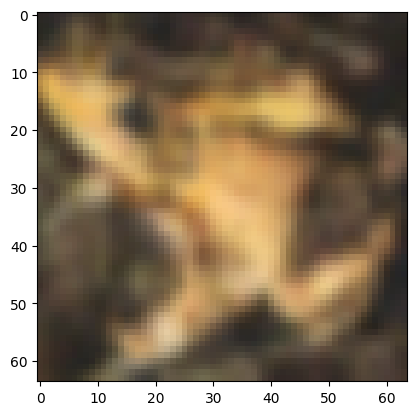

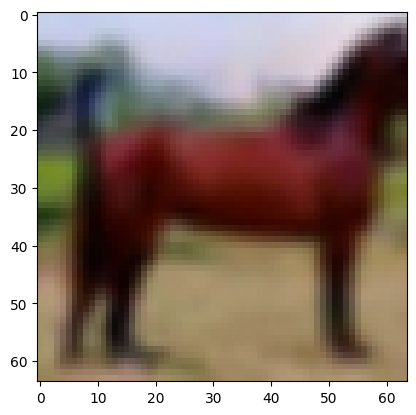

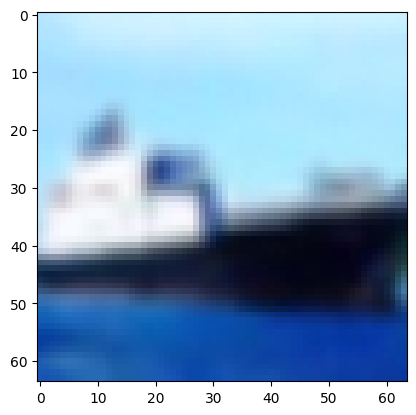

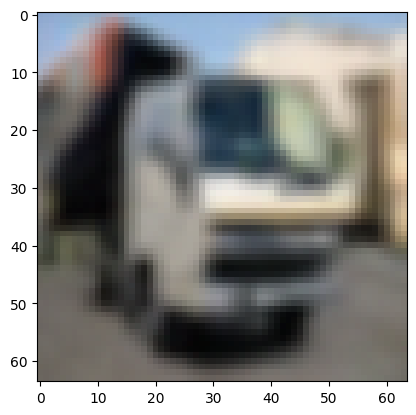

100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #201
Current learning rate is 4.830582022357472e-05
Train Loss is: 0.009122212956659496


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #202
Current learning rate is 4.787106784156255e-05
Train Loss is: 0.009185309760272502


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #203
Current learning rate is 4.744022823098849e-05
Train Loss is: 0.009058104120194912


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #204
Current learning rate is 4.701326617690959e-05
Train Loss is: 0.009022818588651716


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #205
Current learning rate is 4.6590146781317406e-05
Train Loss is: 0.009082805956713855


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #206
Current learning rate is 4.617083546028555e-05
Train Loss is: 0.009090194000862539


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #207
Current learning rate is 4.575529794114298e-05
Train Loss is: 0.00922829811181873


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #208
Current learning rate is 4.534350025967269e-05
Train Loss is: 0.0091249292017892


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #209
Current learning rate is 4.493540875733564e-05
Train Loss is: 0.009077938436530531


100%|█████████████████████████████████████| 10000/10000 [12:25<00:00, 13.42it/s]


Epoch #210
Current learning rate is 4.453099007851962e-05
Train Loss is: 0.009169844274409115
Valid Loss is: 0.00929585792351063


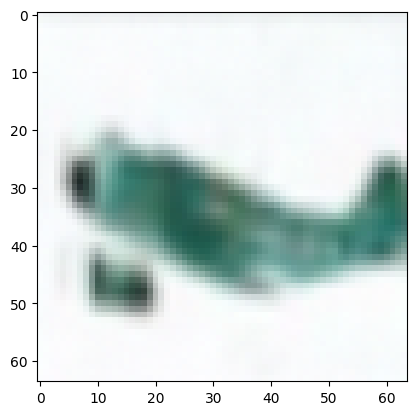

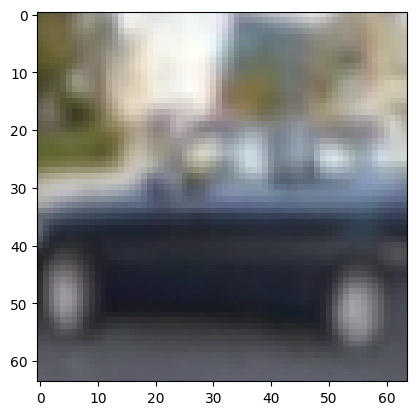

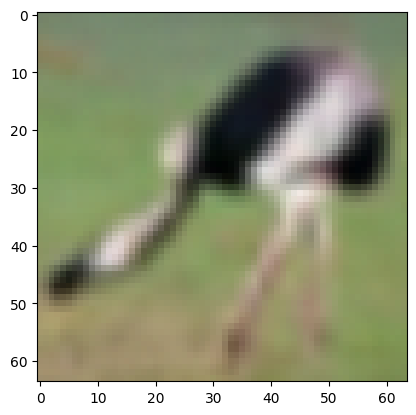

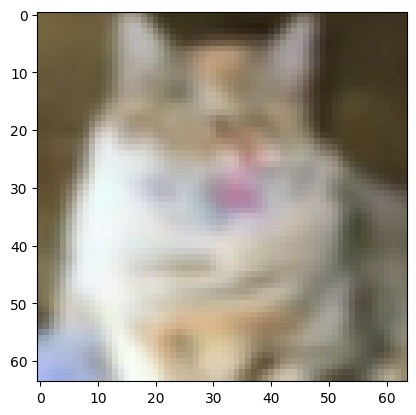

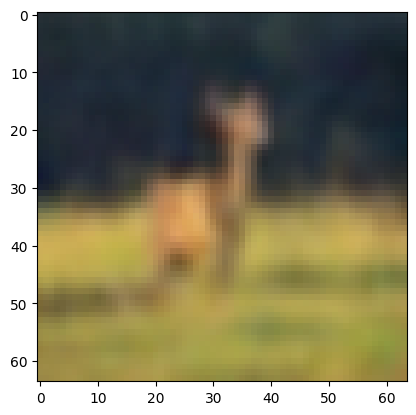

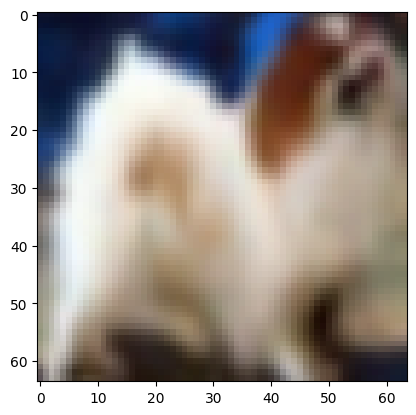

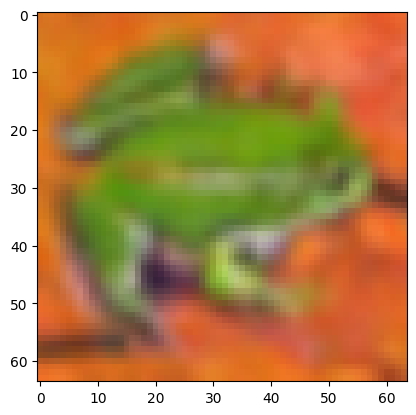

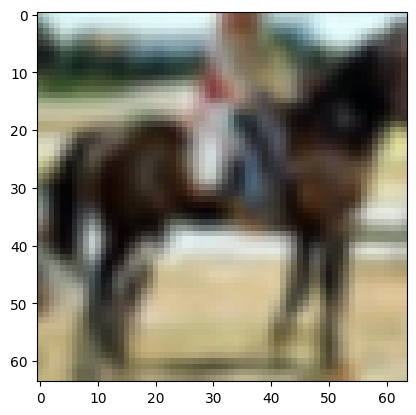

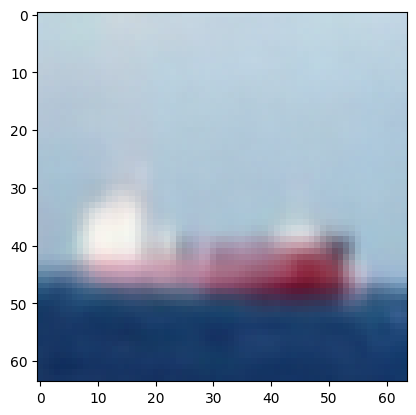

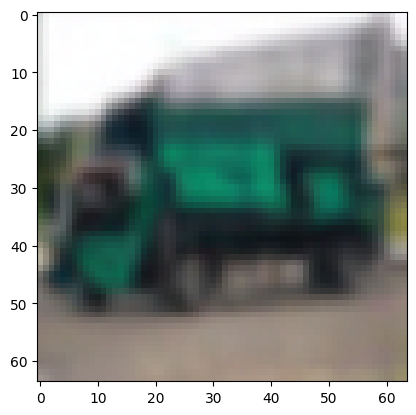

100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #211
Current learning rate is 4.4130211167812944e-05
Train Loss is: 0.009064306498505176


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #212
Current learning rate is 4.373303926730263e-05
Train Loss is: 0.009197120923548937


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #213
Current learning rate is 4.333944191389691e-05
Train Loss is: 0.009240905486047267


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #214
Current learning rate is 4.2949386936671836e-05
Train Loss is: 0.009074523059651255


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #215
Current learning rate is 4.256284245424179e-05
Train Loss is: 0.009090830395929516


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #216
Current learning rate is 4.217977687215361e-05
Train Loss is: 0.008990976097993552


100%|█████████████████████████████████████████| 500/500 [35:09<00:00,  4.22s/it]


Epoch #217
Current learning rate is 4.180015888030423e-05
Train Loss is: 0.009115811145864428


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #218
Current learning rate is 4.142395745038149e-05
Train Loss is: 0.009234910907223821


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #219
Current learning rate is 4.105114183332806e-05
Train Loss is: 0.00918716693110764


100%|█████████████████████████████████████| 10000/10000 [12:25<00:00, 13.42it/s]


Epoch #220
Current learning rate is 4.0681681556828104e-05
Train Loss is: 0.009207723351195454
Valid Loss is: 0.008973415903854948


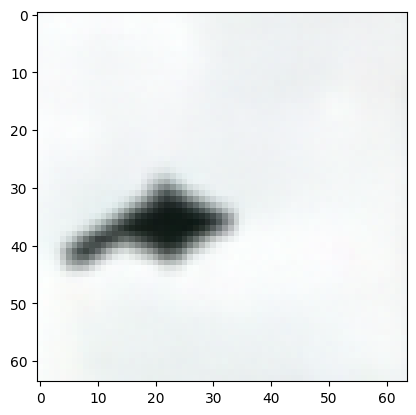

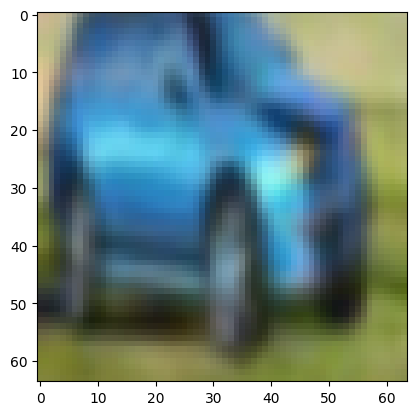

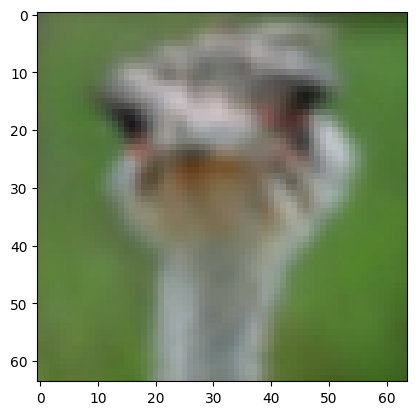

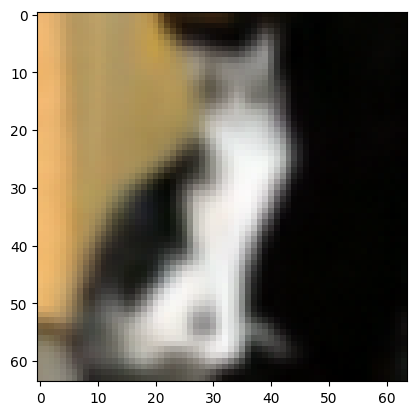

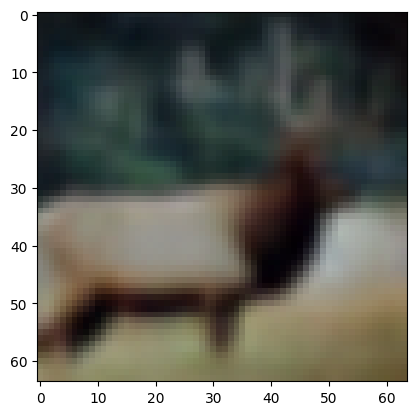

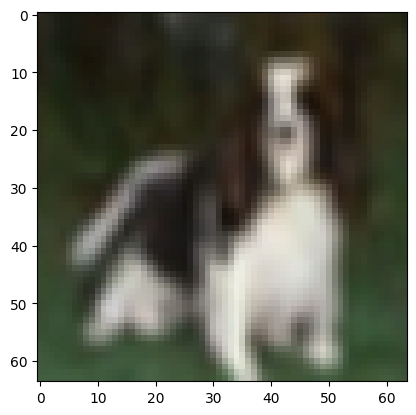

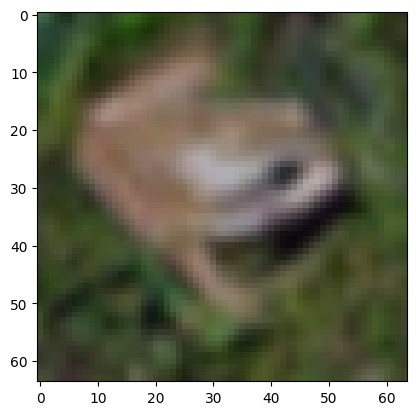

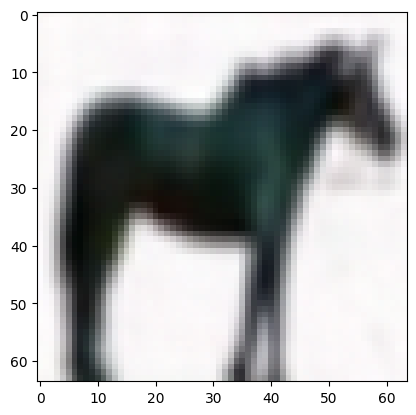

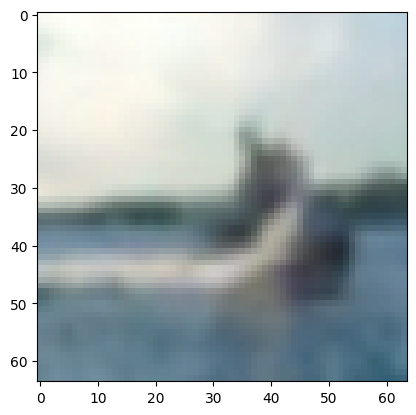

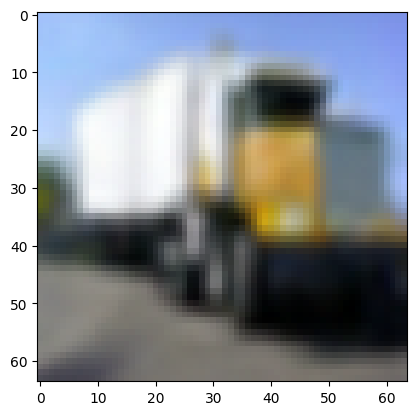

100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #221
Current learning rate is 4.031554642281665e-05
Train Loss is: 0.00916309236548841


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #222
Current learning rate is 3.99527065050113e-05
Train Loss is: 0.009035591833293439


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #223
Current learning rate is 3.95931321464662e-05
Train Loss is: 0.009032802578061818


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #224
Current learning rate is 3.9236793957148e-05
Train Loss is: 0.009137385279871523


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #225
Current learning rate is 3.8883662811533665e-05
Train Loss is: 0.009029306751675905


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.22s/it]


Epoch #226
Current learning rate is 3.853370984622986e-05
Train Loss is: 0.009033937168307603


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #227
Current learning rate is 3.818690645761379e-05
Train Loss is: 0.009064746554940939


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #228
Current learning rate is 3.784322429949527e-05
Train Loss is: 0.009058992397971451


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #229
Current learning rate is 3.750263528079981e-05
Train Loss is: 0.009125519681721926


100%|█████████████████████████████████████| 10000/10000 [12:26<00:00, 13.39it/s]


Epoch #230
Current learning rate is 3.716511156327261e-05
Train Loss is: 0.009104694738984108
Valid Loss is: 0.009015664561302492


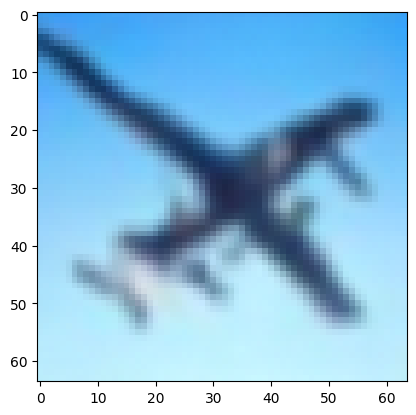

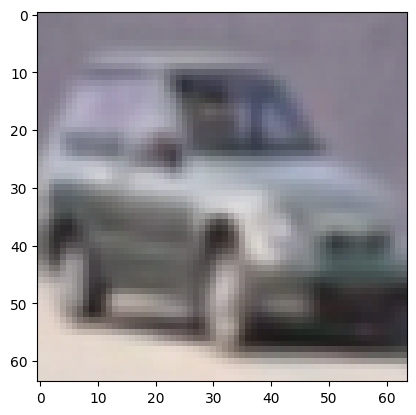

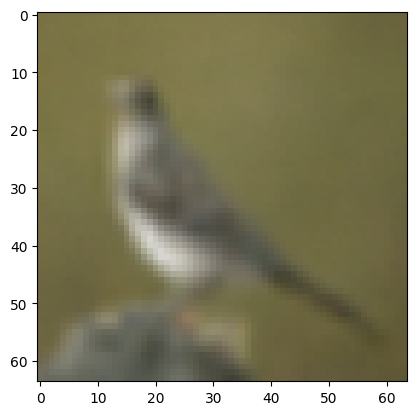

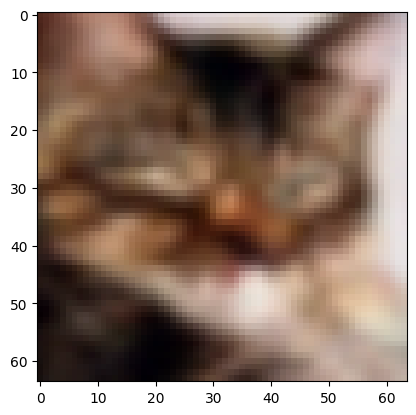

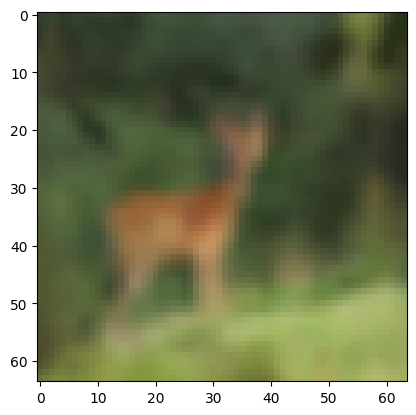

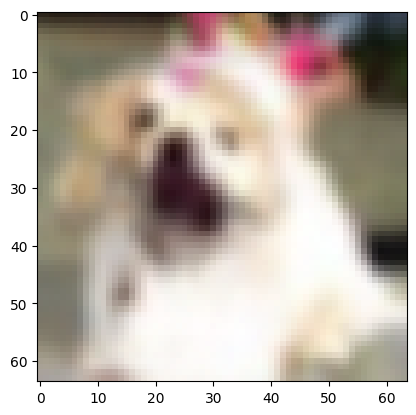

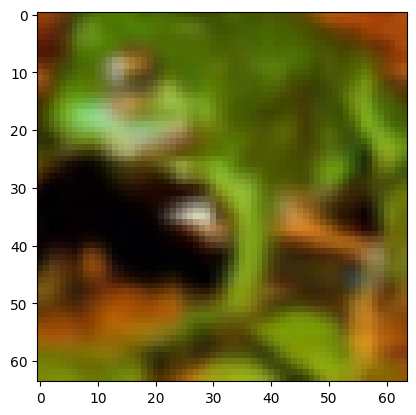

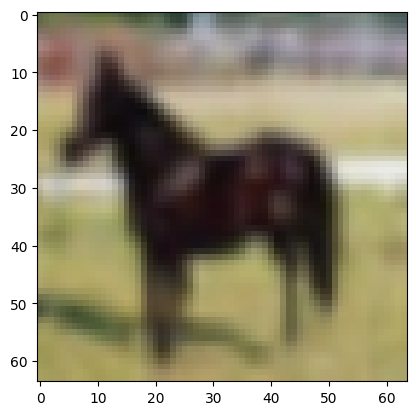

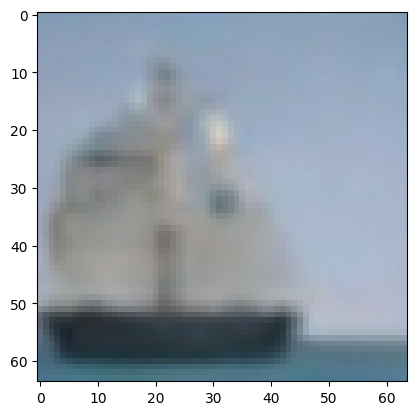

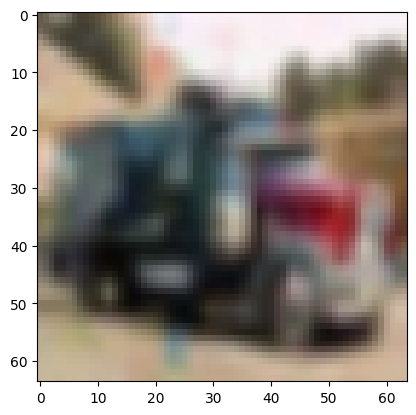

100%|█████████████████████████████████████████| 500/500 [35:14<00:00,  4.23s/it]


Epoch #231
Current learning rate is 3.683062555920316e-05
Train Loss is: 0.009196209494024514


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #232
Current learning rate is 3.649914992917033e-05
Train Loss is: 0.009052239703945815


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #233
Current learning rate is 3.617065757980779e-05
Train Loss is: 0.009186352851800621


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #234
Current learning rate is 3.584512166158952e-05
Train Loss is: 0.009014619955793023


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #235
Current learning rate is 3.552251556663522e-05
Train Loss is: 0.009022311417385936


100%|█████████████████████████████████████████| 500/500 [35:10<00:00,  4.22s/it]


Epoch #236
Current learning rate is 3.52028129265355e-05
Train Loss is: 0.00906199956778437


100%|█████████████████████████████████████████| 500/500 [35:13<00:00,  4.23s/it]


Epoch #237
Current learning rate is 3.488598761019668e-05
Train Loss is: 0.009169339695945381


100%|█████████████████████████████████████████| 500/500 [35:14<00:00,  4.23s/it]


Epoch #238
Current learning rate is 3.457201372170491e-05
Train Loss is: 0.00908703165780753


100%|█████████████████████████████████████████| 500/500 [35:14<00:00,  4.23s/it]


Epoch #239
Current learning rate is 3.4260865598209565e-05
Train Loss is: 0.00903932923823595


100%|█████████████████████████████████████| 10000/10000 [12:51<00:00, 12.97it/s]


Epoch #240
Current learning rate is 3.395251780782568e-05
Train Loss is: 0.008975591608323157
Valid Loss is: 0.00916256052196386


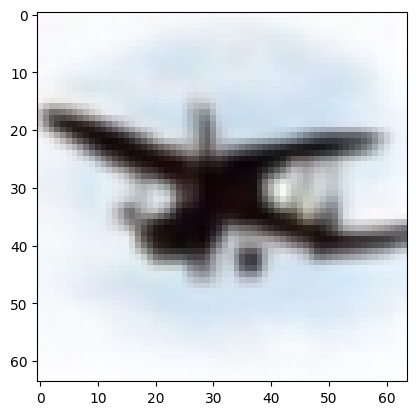

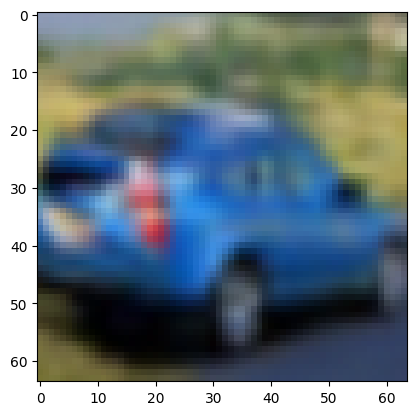

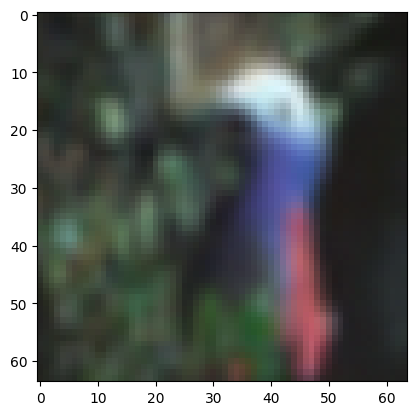

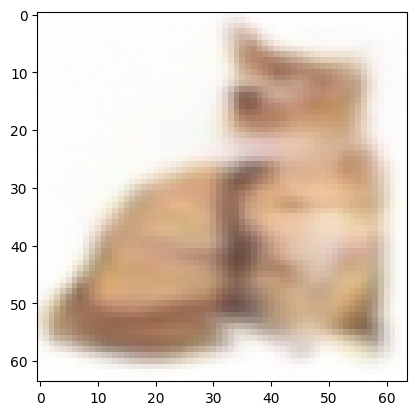

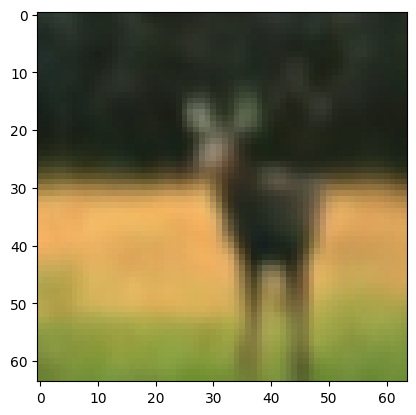

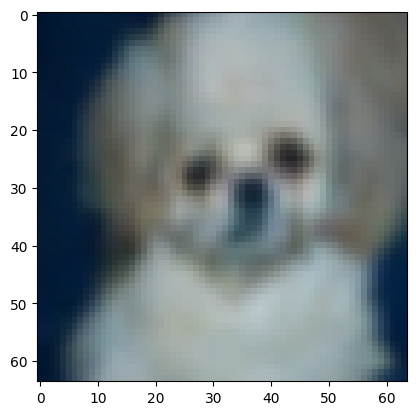

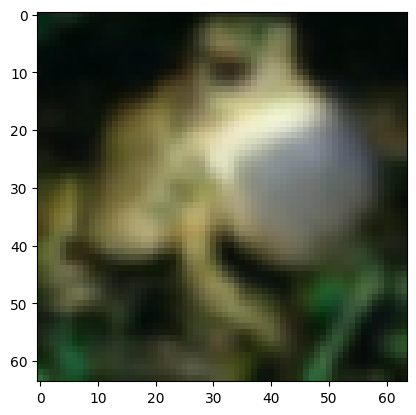

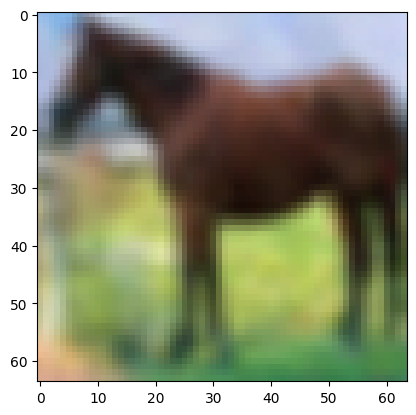

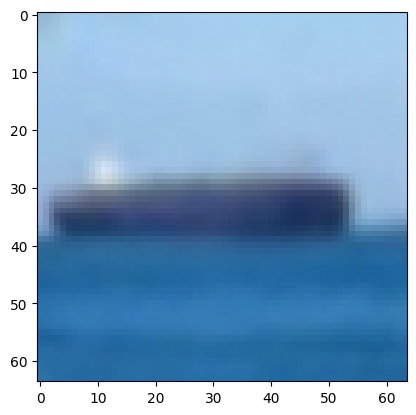

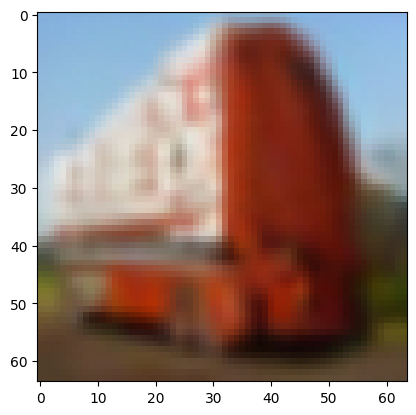

100%|█████████████████████████████████████████| 500/500 [35:16<00:00,  4.23s/it]


Epoch #241
Current learning rate is 3.364694514755525e-05
Train Loss is: 0.009096331033855676


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #242
Current learning rate is 3.334412264122725e-05
Train Loss is: 0.009033730125054717


100%|█████████████████████████████████████████| 500/500 [35:16<00:00,  4.23s/it]


Epoch #243
Current learning rate is 3.304402553745621e-05
Train Loss is: 0.009006694045849145


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #244
Current learning rate is 3.27466293076191e-05
Train Loss is: 0.009067313490435481


100%|█████████████████████████████████████████| 500/500 [35:16<00:00,  4.23s/it]


Epoch #245
Current learning rate is 3.2451909643850524e-05
Train Loss is: 0.009041414158418774


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #246
Current learning rate is 3.2159842457055866e-05
Train Loss is: 0.009014127287082374


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #247
Current learning rate is 3.1870403874942365e-05
Train Loss is: 0.009109274552203716


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #248
Current learning rate is 3.1583570240067885e-05
Train Loss is: 0.0090840599918738


100%|█████████████████████████████████████████| 500/500 [35:16<00:00,  4.23s/it]


Epoch #249
Current learning rate is 3.129931810790728e-05
Train Loss is: 0.009176465535536409


100%|█████████████████████████████████████| 10000/10000 [12:50<00:00, 12.97it/s]


Epoch #250
Current learning rate is 3.101762424493611e-05
Train Loss is: 0.009175042956136166
Valid Loss is: 0.009303896314620579


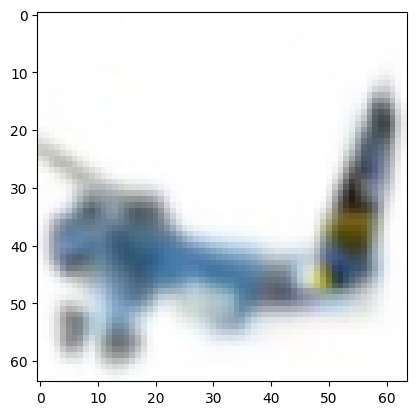

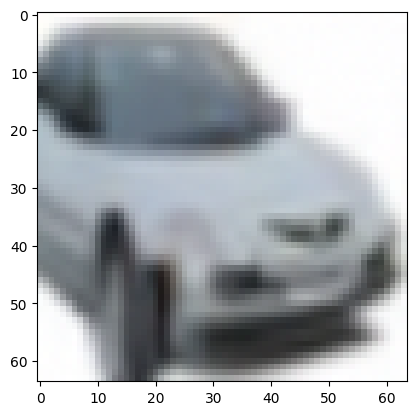

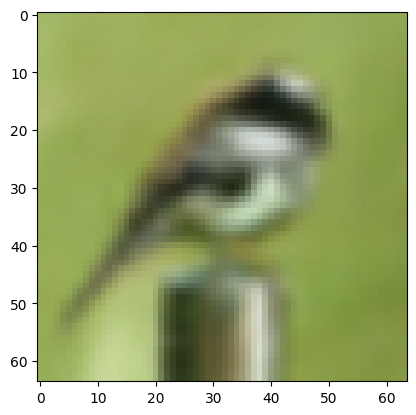

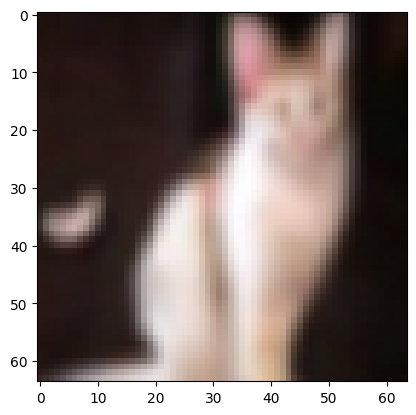

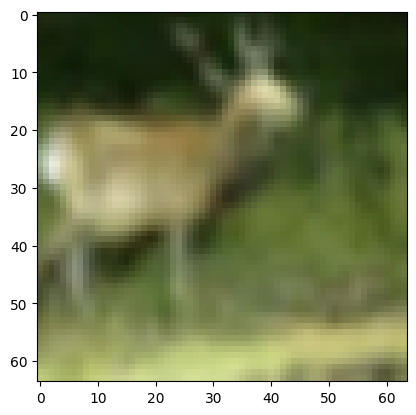

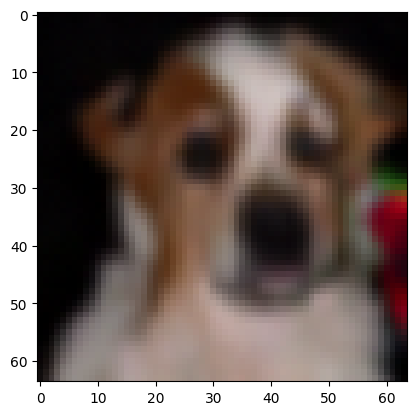

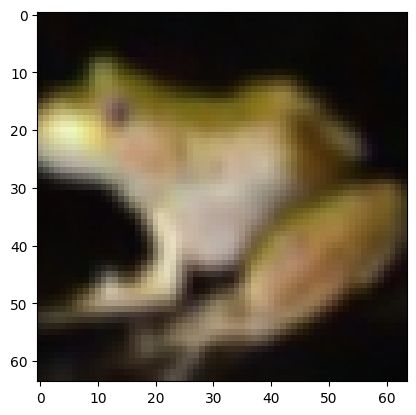

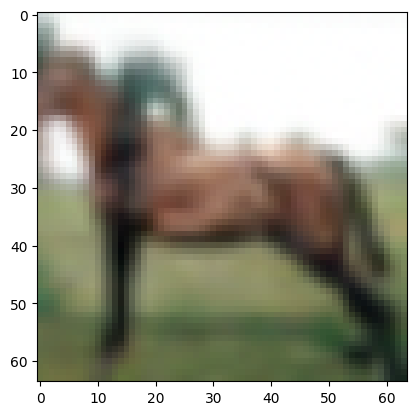

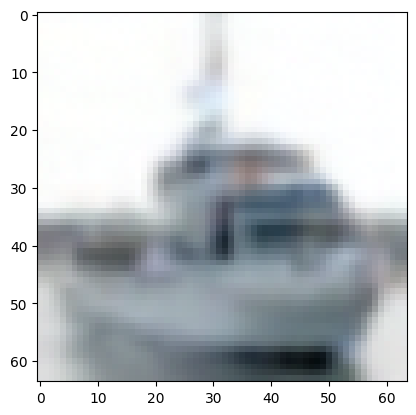

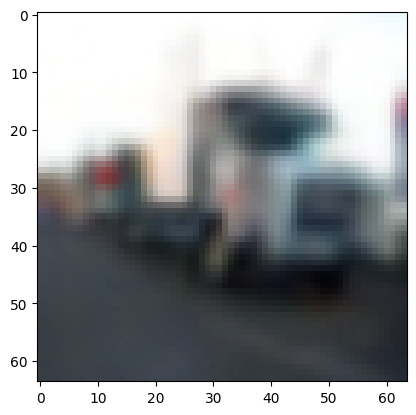

100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #251
Current learning rate is 3.073846562673169e-05
Train Loss is: 0.009055393369868398


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #252
Current learning rate is 3.04618194360911e-05
Train Loss is: 0.009111204898916186


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #253
Current learning rate is 3.018766306116628e-05
Train Loss is: 0.008978010111488402


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #254
Current learning rate is 2.9915974093615784e-05
Train Loss is: 0.008949500179849565


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #255
Current learning rate is 2.9646730326773243e-05
Train Loss is: 0.00897254251409322


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.23s/it]


Epoch #256
Current learning rate is 2.9379909753832283e-05
Train Loss is: 0.009101941862143576


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #257
Current learning rate is 2.9115490566047794e-05
Train Loss is: 0.009136148711666466


100%|█████████████████████████████████████████| 500/500 [35:16<00:00,  4.23s/it]


Epoch #258
Current learning rate is 2.8853451150953364e-05
Train Loss is: 0.00913196968846023


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #259
Current learning rate is 2.8593770090594783e-05
Train Loss is: 0.00904471483733505


100%|█████████████████████████████████████| 10000/10000 [12:50<00:00, 12.98it/s]


Epoch #260
Current learning rate is 2.833642615977943e-05
Train Loss is: 0.008990101544186472
Valid Loss is: 0.009280771831528728


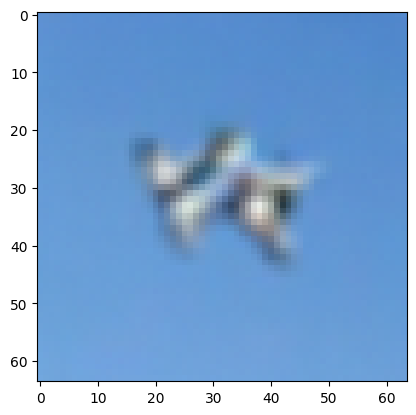

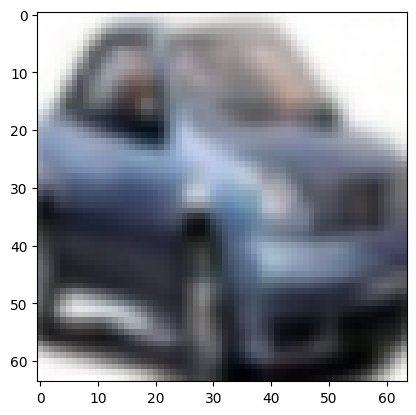

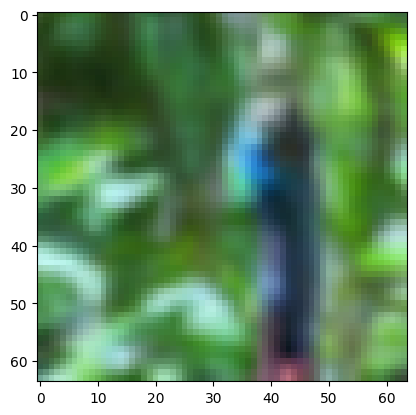

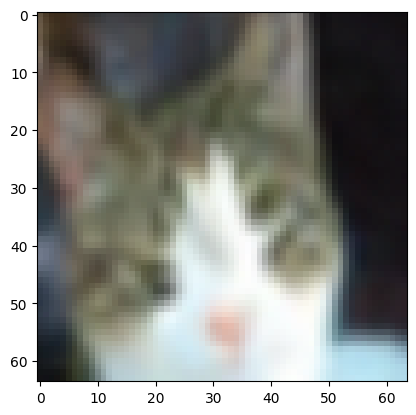

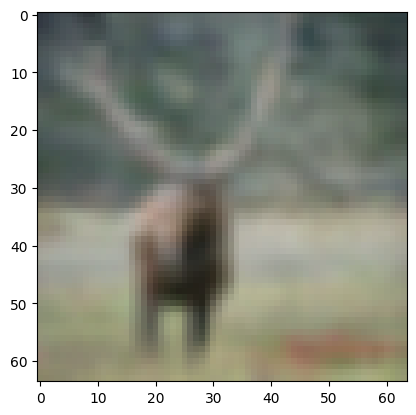

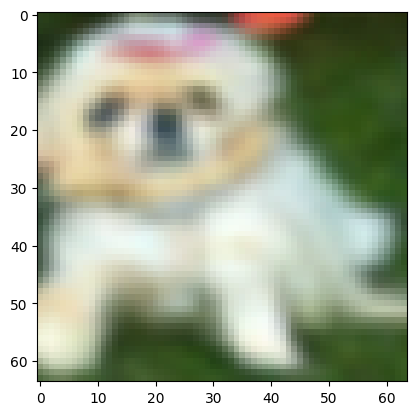

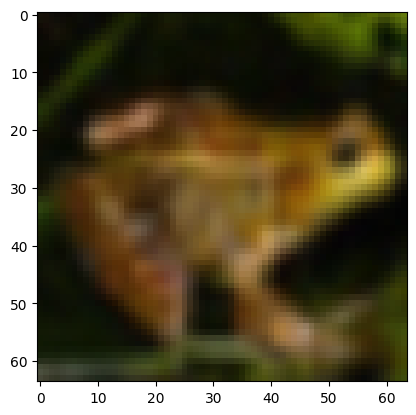

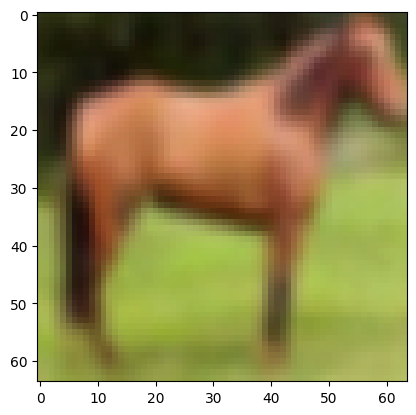

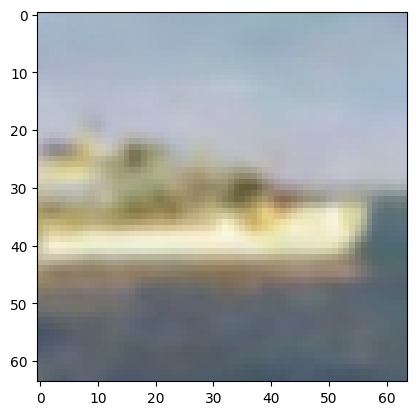

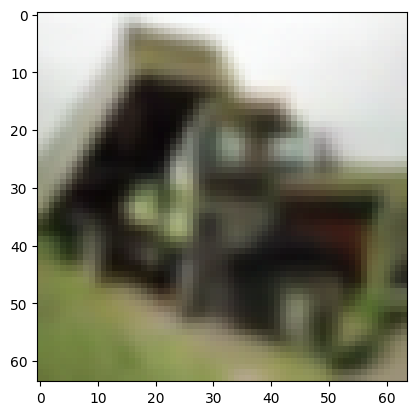

100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #261
Current learning rate is 2.8081398324341414e-05
Train Loss is: 0.009113479888066649


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #262
Current learning rate is 2.7828665739422342e-05
Train Loss is: 0.009099411618895829


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #263
Current learning rate is 2.7578207747767542e-05
Train Loss is: 0.009039503673091531


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #264
Current learning rate is 2.7330003878037635e-05
Train Loss is: 0.00903565183840692


100%|█████████████████████████████████████████| 500/500 [35:15<00:00,  4.23s/it]


Epoch #265
Current learning rate is 2.7084033843135295e-05
Train Loss is: 0.009019273666664957


100%|█████████████████████████████████████████| 500/500 [35:14<00:00,  4.23s/it]


Epoch #266
Current learning rate is 2.6840277538547077e-05
Train Loss is: 0.009000385738909244


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.22s/it]


Epoch #267
Current learning rate is 2.659871504070015e-05
Train Loss is: 0.009059989090077578


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #268
Current learning rate is 2.635932660533385e-05
Train Loss is: 0.009017096974886955


100%|█████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


Epoch #269
Current learning rate is 2.6122092665885844e-05
Train Loss is: 0.00910361488442868


100%|█████████████████████████████████████| 10000/10000 [12:39<00:00, 13.17it/s]


Epoch #270
Current learning rate is 2.5886993831892873e-05
Train Loss is: 0.009024174417369068
Valid Loss is: 0.0089805527811523


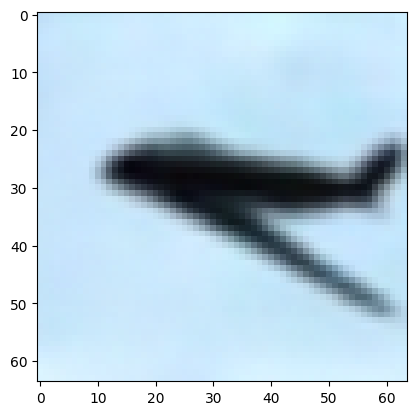

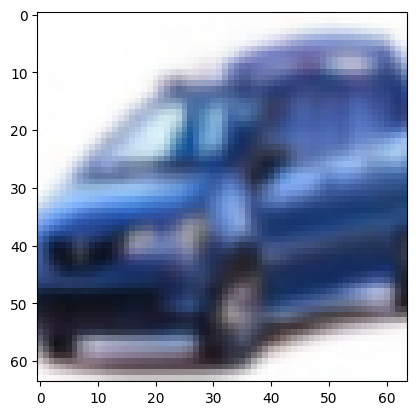

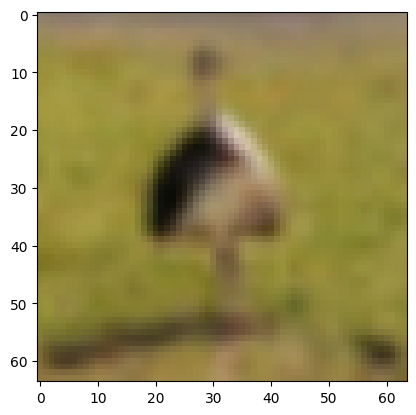

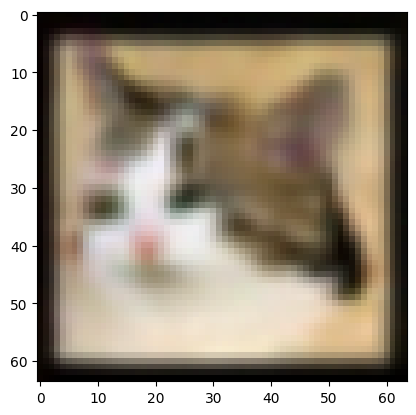

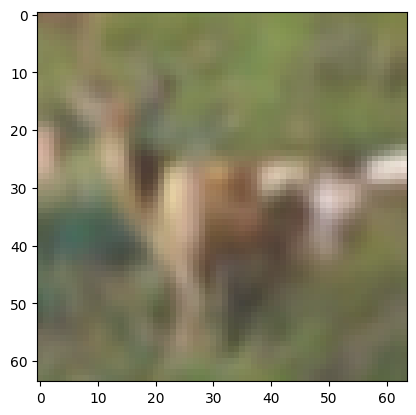

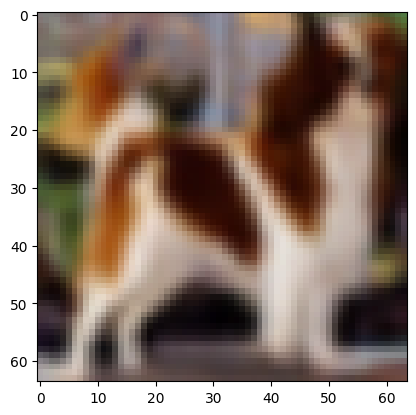

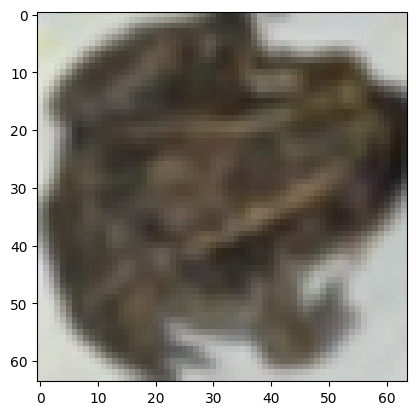

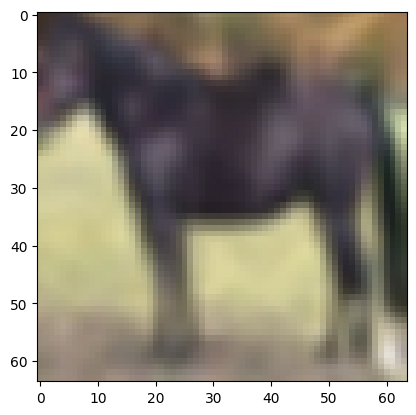

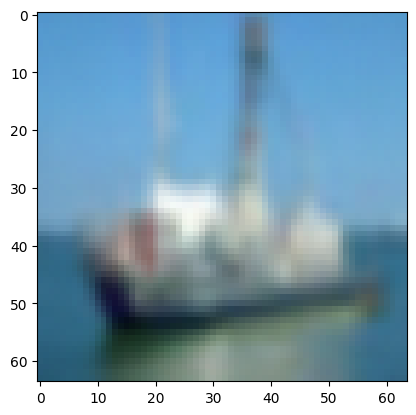

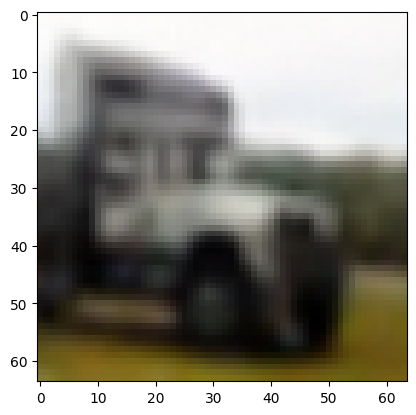

100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.22s/it]


Epoch #271
Current learning rate is 2.5654010887405837e-05
Train Loss is: 0.008975593600422145


100%|█████████████████████████████████████████| 500/500 [35:12<00:00,  4.22s/it]


Epoch #272
Current learning rate is 2.5423124789419185e-05
Train Loss is: 0.009142408590763807


 53%|█████████████████████▌                   | 263/500 [18:30<16:42,  4.23s/it]

In [ ]:
# Training
ema = EMA(0.9999) # 0.9999 according to the diffusion model beat GANs paper.
ema_model = copy.deepcopy(unet).eval().requires_grad_(False)
for epoch in range(epochs):
    train_loss_list = []
    valid_loss_list = []
    for images, label in tqdm(train_dataloader):
        # Zero out grad\
        optimizer.zero_grad()

        # Preparing for forward pass
        images = images.to(device)
        label = label.to(device)
        t = torch.randint(1, steps, size = (images.shape[0], )).to(device)
        pos_emb = pos_emb_matrix[t]
        x_t, noise = forward_pass(images, t)

        # Classifier free guidance.
        if random.random() < 0.1:
            label = None

        # Forward pass
        with amp.autocast():
            predicted_noise = unet(x_t, pos_emb, label)
            loss = criterion(predicted_noise, noise)

        # Back propagation
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # EMA and loss
        ema.step_ema(ema_model, unet)
        train_loss_list.append(loss.item())
    
    if(epoch % 10 == 0):
        with torch.no_grad():
            for images, label in tqdm(valid_dataloader):
                # Preparing for forward pass
                images = images.to(device)
                label = label.to(device)
                t = torch.randint(1, steps, size = (images.shape[0], ))
                pos_emb = pos_emb_matrix[t].to(device)
                x_t, noise = forward_pass(images, t)
    
                # Forward pass
                with amp.autocast():
                    predicted_noise = unet(x_t, pos_emb, label)
                    loss = criterion(predicted_noise, noise)
                valid_loss_list.append(loss.item())

    # Step the learning rate
    scheduler.step()

    print(f"Epoch #{epoch}")
    print(f"Current learning rate is {optimizer.param_groups[0]['lr']}")
    print("Train Loss is:", sum(train_loss_list)/len(train_loss_list))
    loss_train.append(sum(train_loss_list)/len(train_loss_list))
    if(epoch % 10 == 0):
        print("Valid Loss is:", sum(valid_loss_list)/len(valid_loss_list))
        loss_valid.append(sum(valid_loss_list)/len(valid_loss_list))
    if(epoch % 10 == 0):
        label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)
        sampling(ema_model, label)

# Testing

#### label = torch.tensor([0, 0, 0, 0, 0]).to(device)
sampling(ema_model, label, 4)

In [ ]:
torch.save(ema_model, "diffusion_CIFAR10.pth")

In [ ]:
torch.save(unet, "diffusion_CIFAR10_student.pth")